In [1]:
%matplotlib notebook

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchgp.symbolic import *
from torchgp.transforms import *
from torchgp.reparameterization import *
from torchgp.test_tools import *
from torchgp.kernels import *
from torchgp.parameterizations.titsias import *
import math
import networkx as nx
from matplotlib.pyplot import *

In [2]:
data_gen = SASE1DSignal(50,200)
y, X = data_gen.make_fake_data(100000)
gt = (data_gen.mean_A()/data_gen.n_A)
yc = y + torch.randn(100000,1)/10

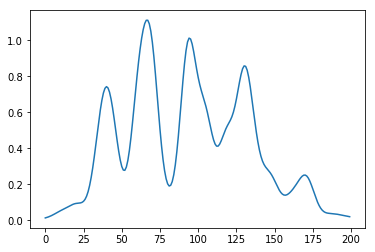

In [3]:
figure()
plot(gt.numpy())

## Example 1

1. 1D GPMM Signal
2. Gaussian likelihood with gaussian noise
3. MC Evaluation of likelihood
4. Full covariance used in reparameterization gradients (not necessary in this case, but used nonetheless)

In [30]:
class VFE_1D_GPMM_Reparam_FullCov(torch.nn.Module):
    def __init__(self, F0, Ntotal, Nmc = 10, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        λ0 = Vector('λ0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_1D(K0, f0, λ0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = weighted_1D_mean(K0, f0, f0, m, X)
        varf = weighted_var_posterior_fullcov_fullrank(K0, f0, λ0, X, jitter)
        stdf = CholeskyRoot(AddJitter(varf,jitter))
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = stdf @ ϵ + mf
        ve_loss = gaussian_likelihood(y, z, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean_1D(K0, f0, f0, m)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        varf = ExtractDiagonal(var_posterior_fullcov_fullrank(K0, f0, λ0, jitter))
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((F0,1),dtype=self.dtype)/(F0)),
                'λ0': torch.nn.Parameter(5*torch.ones((F0,1),dtype=self.dtype)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                })
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred

In [31]:
m = VFE_1D_GPMM_Reparam_FullCov(200,100000,Nmc=1,std_lik_init=2.0,lenscale_init=0.05)
# m.hyper_params['u0'].requires_grad = False
# m.hyper_params['u1'].requires_grad = False
# m.stored_K['K0']._lengthscale_storage.requires_grad = False
# m.stored_K['K0']._amplitude_storage.requires_grad = False
# m.stored_K['K1']._lengthscale_storage.requires_grad = False
# m.stored_K['K1']._amplitude_storage.requires_grad = False
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-2)
epochs = 5000
scheduler = StepLR(optimizer,50,gamma=0.95)

data = TensorDataset(X, yc)
Logger = ScalarLogger(m, {'hyper_params.std_lik': m._makepos,
                          'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=1000)
    for Xb,yb in d:
        ybc, Xbc = yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: hyper_params.std_lik: 1.17721, stored_K.K0._lengthscale_storage: 0.0460262, stored_K.K0._amplitude_storage: 0.934266, loss: 12410.2, step_size: 0.01, 
epoch 1: hyper_params.std_lik: 0.578697, stored_K.K0._lengthscale_storage: 0.041695, stored_K.K0._amplitude_storage: 0.850987, loss: 5576.47, step_size: 0.01, 
epoch 2: hyper_params.std_lik: 0.401925, stored_K.K0._lengthscale_storage: 0.034772, stored_K.K0._amplitude_storage: 0.735193, loss: 1115.79, step_size: 0.01, 
epoch 3: hyper_params.std_lik: 0.292771, stored_K.K0._lengthscale_storage: 0.0316873, stored_K.K0._amplitude_storage: 0.677451, loss: -1944.8, step_size: 0.01, 
epoch 4: hyper_params.std_lik: 0.277938, stored_K.K0._lengthscale_storage: 0.029323, stored_K.K0._amplitude_storage: 0.627436, loss: -2316.13, step_size: 0.01, 
epoch 5: hyper_params.std_lik: 0.217554, stored_K.K0._lengthscale_storage: 0.0291028, stored_K.K0._amplitude_storage: 0.610191, loss: -2993.48, step_size: 0.01, 
epoch 6: hyper_params.std_lik: 0.199

KeyboardInterrupt: 

In [32]:
m.cpu()

VFE_1D_GPMM_Reparam_FullCov(
  (variational_params): ParameterDict(
      (m): Parameter containing: [torch.FloatTensor of size 200x1]
      (λ0): Parameter containing: [torch.FloatTensor of size 200x1]
  )
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 200x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0244]]), amplitude=0.48614802956581116)
  )
)

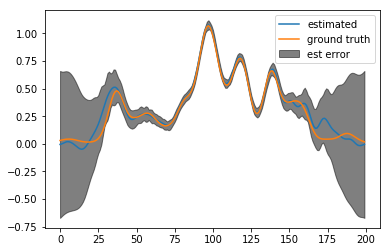

In [33]:
figure()
μ = m.predict_mean().detach().squeeze().numpy()
σ = m.predict_var().detach().sqrt().squeeze().numpy()
plot(μ, label='estimated')
fill_between(np.arange(200),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(gt.numpy(),label='ground truth')
legend()

## Example 2

1. 1D GPMM Signal
2. Poisson likelihood with poisson noise
3. MC Evaluation of likelihood
4. Full covariance used in reparameterization gradients (not necessary in this case, but used nonetheless)

In [7]:
data_gen = SASE1DSignal(50,200,sase_width_factor=1)
y, X = data_gen.make_fake_data(1000000)
gt = (data_gen.mean_A()/data_gen.n_A)
yc = torch.from_numpy(np.random.poisson(y.numpy()).astype('float32'))

<IPython.core.display.Javascript object>


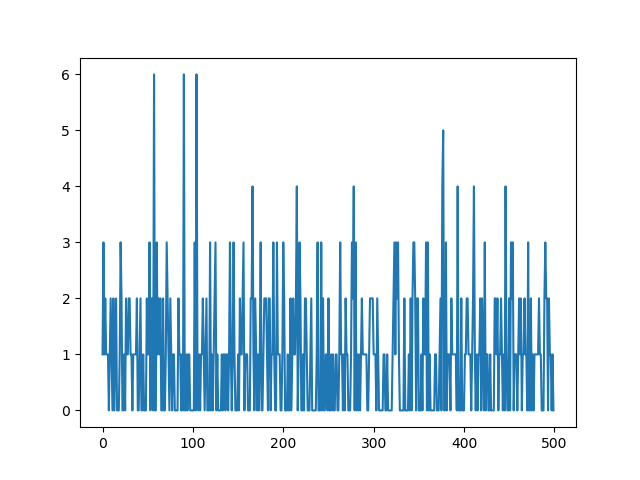

In [10]:
figure()
plot(yc[:500,0].squeeze().numpy())

In [13]:
figure()
plot(X[0].numpy())

<IPython.core.display.Javascript object>

In [14]:
figure()
hist(yc.numpy(),100,density=True);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


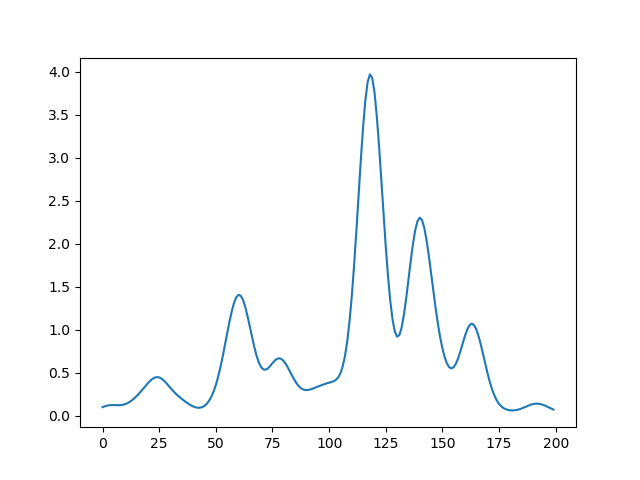

In [15]:
figure()
plot(gt.numpy())

In [16]:
class VFE_1D_GPMM_Reparam_FullCov_Poisson(torch.nn.Module):
    def __init__(self, F0, Ntotal, Nmc = 10, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        λ0 = Vector('λ0')
        f0 = Vector('f0')
        K0 = Kernel('K0')
        y = Vector('y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
#         std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_1D(K0, f0, λ0, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = mean_1D(K0, f0, f0, m)
#         mf = m
        varf = var_posterior_fullcov_fullrank(K0, f0, λ0, jitter)
        varf_diag = ExtractDiagonal(varf)
        stdf = CholeskyRoot(AddJitter(varf,jitter))
        
        ### write out prediction functions while we're here ###
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var_pred"), varf_diag))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var_pred_full"), varf))
        self._var_pred_full = graph2ast(graph, compiled=True, debug=False)
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        z = stdf @ ϵ + mf
        z = X @ Softhinge(z,Constant(10.0))
        ve_loss = poisson_likelihood(y, z, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((F0,1),dtype=self.dtype)/(F0)),
                'λ0': torch.nn.Parameter(5*torch.ones((F0,1),dtype=self.dtype)),
            })
            self.hyper_params = torch.nn.ParameterDict({
#                 'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]),
                                   amplitude=lenscale_init,
                                   transforms=[self._makepos, self._makepos]),
                })
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, y, X):
        leaves = {
            'y': y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred
    def predict_var_full(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
        }
        result = self._var_pred_full(**leaves)
        return result.var_pred_full

In [36]:
m = VFE_1D_GPMM_Reparam_FullCov_Poisson(200,1000000,Nmc=10,lenscale_init=0.005)
# m.hyper_params['u0'].requires_grad = False
# m.hyper_params['u1'].requires_grad = False
# m.stored_K['K0']._lengthscale_storage.requires_grad = False
# m.stored_K['K0']._amplitude_storage.requires_grad = False
# m.stored_K['K1']._lengthscale_storage.requires_grad = False
# m.stored_K['K1']._amplitude_storage.requires_grad = False
m.cuda()
optimizer = torch.optim.Adam(m.parameters(),lr=1e-1)
epochs = 5000
scheduler = StepLR(optimizer,50,gamma=0.92)

data = TensorDataset(X, yc)
Logger = ScalarLogger(m, {'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs):
    d = DataLoader(dataset=data, shuffle=True, batch_size=50000)
    for Xb,yb in d:
        ybc, Xbc = yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(ybc,Xbc)
#         loss = m.loss(yb,Xb)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: stored_K.K0._lengthscale_storage: 0.035217, stored_K.K0._amplitude_storage: 0.0401478, loss: 1.33562e+06, step_size: 0.1, 
epoch 1: stored_K.K0._lengthscale_storage: 0.0301106, stored_K.K0._amplitude_storage: 0.0378991, loss: 1.30734e+06, step_size: 0.1, 
epoch 2: stored_K.K0._lengthscale_storage: 0.0324151, stored_K.K0._amplitude_storage: 0.0411161, loss: 1.26148e+06, step_size: 0.1, 
epoch 3: stored_K.K0._lengthscale_storage: 0.0335118, stored_K.K0._amplitude_storage: 0.042472, loss: 1.25525e+06, step_size: 0.1, 
epoch 4: stored_K.K0._lengthscale_storage: 0.033418, stored_K.K0._amplitude_storage: 0.0423359, loss: 1.25437e+06, step_size: 0.1, 
epoch 5: stored_K.K0._lengthscale_storage: 0.0331327, stored_K.K0._amplitude_storage: 0.0419566, loss: 1.25869e+06, step_size: 0.1, 
epoch 6: stored_K.K0._lengthscale_storage: 0.0335632, stored_K.K0._amplitude_storage: 0.0424329, loss: 1.25433e+06, step_size: 0.1, 
epoch 7: stored_K.K0._lengthscale_storage: 0.0336355, stored_K.K0._ampli

epoch 62: stored_K.K0._lengthscale_storage: 0.0374012, stored_K.K0._amplitude_storage: 0.056017, loss: 1.25432e+06, step_size: 0.092, 
epoch 63: stored_K.K0._lengthscale_storage: 0.0374744, stored_K.K0._amplitude_storage: 0.056286, loss: 1.25098e+06, step_size: 0.092, 
epoch 64: stored_K.K0._lengthscale_storage: 0.0374642, stored_K.K0._amplitude_storage: 0.0564475, loss: 1.25512e+06, step_size: 0.092, 
epoch 65: stored_K.K0._lengthscale_storage: 0.037338, stored_K.K0._amplitude_storage: 0.0564011, loss: 1.2569e+06, step_size: 0.092, 
epoch 66: stored_K.K0._lengthscale_storage: 0.0373023, stored_K.K0._amplitude_storage: 0.0565548, loss: 1.25298e+06, step_size: 0.092, 
epoch 67: stored_K.K0._lengthscale_storage: 0.0375886, stored_K.K0._amplitude_storage: 0.057103, loss: 1.25189e+06, step_size: 0.092, 
epoch 68: stored_K.K0._lengthscale_storage: 0.0373134, stored_K.K0._amplitude_storage: 0.0568561, loss: 1.25361e+06, step_size: 0.092, 
epoch 69: stored_K.K0._lengthscale_storage: 0.0377632

epoch 122: stored_K.K0._lengthscale_storage: 0.0419771, stored_K.K0._amplitude_storage: 0.0637519, loss: 1.2535e+06, step_size: 0.08464, 
epoch 123: stored_K.K0._lengthscale_storage: 0.0422196, stored_K.K0._amplitude_storage: 0.0640578, loss: 1.25297e+06, step_size: 0.08464, 
epoch 124: stored_K.K0._lengthscale_storage: 0.0421848, stored_K.K0._amplitude_storage: 0.0639981, loss: 1.2564e+06, step_size: 0.08464, 
epoch 125: stored_K.K0._lengthscale_storage: 0.0421008, stored_K.K0._amplitude_storage: 0.0637899, loss: 1.25373e+06, step_size: 0.08464, 
epoch 126: stored_K.K0._lengthscale_storage: 0.0423637, stored_K.K0._amplitude_storage: 0.0641956, loss: 1.25399e+06, step_size: 0.08464, 
epoch 127: stored_K.K0._lengthscale_storage: 0.0426696, stored_K.K0._amplitude_storage: 0.0646845, loss: 1.25173e+06, step_size: 0.08464, 
epoch 128: stored_K.K0._lengthscale_storage: 0.0425153, stored_K.K0._amplitude_storage: 0.0644898, loss: 1.25369e+06, step_size: 0.08464, 
epoch 129: stored_K.K0._lengt

epoch 181: stored_K.K0._lengthscale_storage: 0.0457802, stored_K.K0._amplitude_storage: 0.0715834, loss: 1.25245e+06, step_size: 0.0778688, 
epoch 182: stored_K.K0._lengthscale_storage: 0.0459332, stored_K.K0._amplitude_storage: 0.0717966, loss: 1.25442e+06, step_size: 0.0778688, 
epoch 183: stored_K.K0._lengthscale_storage: 0.0462645, stored_K.K0._amplitude_storage: 0.0725901, loss: 1.25053e+06, step_size: 0.0778688, 
epoch 184: stored_K.K0._lengthscale_storage: 0.0459694, stored_K.K0._amplitude_storage: 0.0721707, loss: 1.25363e+06, step_size: 0.0778688, 
epoch 185: stored_K.K0._lengthscale_storage: 0.0460364, stored_K.K0._amplitude_storage: 0.0725078, loss: 1.25527e+06, step_size: 0.0778688, 
epoch 186: stored_K.K0._lengthscale_storage: 0.0459548, stored_K.K0._amplitude_storage: 0.0724932, loss: 1.25466e+06, step_size: 0.0778688, 
epoch 187: stored_K.K0._lengthscale_storage: 0.0459803, stored_K.K0._amplitude_storage: 0.0725206, loss: 1.25044e+06, step_size: 0.0778688, 
epoch 188: st

epoch 240: stored_K.K0._lengthscale_storage: 0.0482502, stored_K.K0._amplitude_storage: 0.0802954, loss: 1.25591e+06, step_size: 0.0716393, 
epoch 241: stored_K.K0._lengthscale_storage: 0.0483094, stored_K.K0._amplitude_storage: 0.080518, loss: 1.249e+06, step_size: 0.0716393, 
epoch 242: stored_K.K0._lengthscale_storage: 0.0477652, stored_K.K0._amplitude_storage: 0.0798691, loss: 1.25309e+06, step_size: 0.0716393, 
epoch 243: stored_K.K0._lengthscale_storage: 0.048474, stored_K.K0._amplitude_storage: 0.081431, loss: 1.2512e+06, step_size: 0.0716393, 
epoch 244: stored_K.K0._lengthscale_storage: 0.0478876, stored_K.K0._amplitude_storage: 0.0805054, loss: 1.24725e+06, step_size: 0.0716393, 
epoch 245: stored_K.K0._lengthscale_storage: 0.0482356, stored_K.K0._amplitude_storage: 0.0809648, loss: 1.25055e+06, step_size: 0.0716393, 
epoch 246: stored_K.K0._lengthscale_storage: 0.0484008, stored_K.K0._amplitude_storage: 0.0811564, loss: 1.25243e+06, step_size: 0.0716393, 
epoch 247: stored_K

epoch 299: stored_K.K0._lengthscale_storage: 0.0490672, stored_K.K0._amplitude_storage: 0.0868613, loss: 1.25176e+06, step_size: 0.0659082, 
epoch 300: stored_K.K0._lengthscale_storage: 0.0491948, stored_K.K0._amplitude_storage: 0.087124, loss: 1.25444e+06, step_size: 0.0659082, 
epoch 301: stored_K.K0._lengthscale_storage: 0.048848, stored_K.K0._amplitude_storage: 0.0866323, loss: 1.25007e+06, step_size: 0.0606355, 
epoch 302: stored_K.K0._lengthscale_storage: 0.0494159, stored_K.K0._amplitude_storage: 0.0878131, loss: 1.2553e+06, step_size: 0.0606355, 
epoch 303: stored_K.K0._lengthscale_storage: 0.0490906, stored_K.K0._amplitude_storage: 0.0874311, loss: 1.25769e+06, step_size: 0.0606355, 
epoch 304: stored_K.K0._lengthscale_storage: 0.0493415, stored_K.K0._amplitude_storage: 0.0879303, loss: 1.25164e+06, step_size: 0.0606355, 
epoch 305: stored_K.K0._lengthscale_storage: 0.0493264, stored_K.K0._amplitude_storage: 0.0876055, loss: 1.25131e+06, step_size: 0.0606355, 
epoch 306: store

epoch 358: stored_K.K0._lengthscale_storage: 0.0500069, stored_K.K0._amplitude_storage: 0.0933555, loss: 1.25413e+06, step_size: 0.0557847, 
epoch 359: stored_K.K0._lengthscale_storage: 0.0499238, stored_K.K0._amplitude_storage: 0.0932448, loss: 1.25409e+06, step_size: 0.0557847, 
epoch 360: stored_K.K0._lengthscale_storage: 0.0501071, stored_K.K0._amplitude_storage: 0.0938221, loss: 1.2554e+06, step_size: 0.0557847, 
epoch 361: stored_K.K0._lengthscale_storage: 0.0499054, stored_K.K0._amplitude_storage: 0.0935513, loss: 1.25444e+06, step_size: 0.0557847, 
epoch 362: stored_K.K0._lengthscale_storage: 0.0499349, stored_K.K0._amplitude_storage: 0.0934801, loss: 1.2505e+06, step_size: 0.0557847, 
epoch 363: stored_K.K0._lengthscale_storage: 0.050349, stored_K.K0._amplitude_storage: 0.0942962, loss: 1.25237e+06, step_size: 0.0557847, 
epoch 364: stored_K.K0._lengthscale_storage: 0.0497492, stored_K.K0._amplitude_storage: 0.0934486, loss: 1.24508e+06, step_size: 0.0557847, 
epoch 365: store

epoch 417: stored_K.K0._lengthscale_storage: 0.0504564, stored_K.K0._amplitude_storage: 0.0985967, loss: 1.24986e+06, step_size: 0.0513219, 
epoch 418: stored_K.K0._lengthscale_storage: 0.0507528, stored_K.K0._amplitude_storage: 0.0994784, loss: 1.25871e+06, step_size: 0.0513219, 
epoch 419: stored_K.K0._lengthscale_storage: 0.0504547, stored_K.K0._amplitude_storage: 0.0989565, loss: 1.25245e+06, step_size: 0.0513219, 
epoch 420: stored_K.K0._lengthscale_storage: 0.050926, stored_K.K0._amplitude_storage: 0.0999679, loss: 1.25387e+06, step_size: 0.0513219, 
epoch 421: stored_K.K0._lengthscale_storage: 0.0507575, stored_K.K0._amplitude_storage: 0.0997124, loss: 1.25188e+06, step_size: 0.0513219, 
epoch 422: stored_K.K0._lengthscale_storage: 0.0505768, stored_K.K0._amplitude_storage: 0.0994589, loss: 1.25049e+06, step_size: 0.0513219, 
epoch 423: stored_K.K0._lengthscale_storage: 0.0508376, stored_K.K0._amplitude_storage: 0.100101, loss: 1.24925e+06, step_size: 0.0513219, 
epoch 424: stor

epoch 476: stored_K.K0._lengthscale_storage: 0.0508197, stored_K.K0._amplitude_storage: 0.103597, loss: 1.25177e+06, step_size: 0.0472161, 
epoch 477: stored_K.K0._lengthscale_storage: 0.0507811, stored_K.K0._amplitude_storage: 0.103725, loss: 1.24629e+06, step_size: 0.0472161, 
epoch 478: stored_K.K0._lengthscale_storage: 0.0511239, stored_K.K0._amplitude_storage: 0.10414, loss: 1.25388e+06, step_size: 0.0472161, 
epoch 479: stored_K.K0._lengthscale_storage: 0.0511322, stored_K.K0._amplitude_storage: 0.104446, loss: 1.25788e+06, step_size: 0.0472161, 
epoch 480: stored_K.K0._lengthscale_storage: 0.0510255, stored_K.K0._amplitude_storage: 0.104438, loss: 1.2532e+06, step_size: 0.0472161, 
epoch 481: stored_K.K0._lengthscale_storage: 0.0515616, stored_K.K0._amplitude_storage: 0.105182, loss: 1.25488e+06, step_size: 0.0472161, 
epoch 482: stored_K.K0._lengthscale_storage: 0.0514192, stored_K.K0._amplitude_storage: 0.10503, loss: 1.2499e+06, step_size: 0.0472161, 
epoch 483: stored_K.K0._

epoch 535: stored_K.K0._lengthscale_storage: 0.051169, stored_K.K0._amplitude_storage: 0.107668, loss: 1.2473e+06, step_size: 0.0434388, 
epoch 536: stored_K.K0._lengthscale_storage: 0.0515229, stored_K.K0._amplitude_storage: 0.10833, loss: 1.2544e+06, step_size: 0.0434388, 
epoch 537: stored_K.K0._lengthscale_storage: 0.0510953, stored_K.K0._amplitude_storage: 0.107643, loss: 1.2537e+06, step_size: 0.0434388, 
epoch 538: stored_K.K0._lengthscale_storage: 0.0516274, stored_K.K0._amplitude_storage: 0.108921, loss: 1.25145e+06, step_size: 0.0434388, 
epoch 539: stored_K.K0._lengthscale_storage: 0.0508424, stored_K.K0._amplitude_storage: 0.107336, loss: 1.25000e+06, step_size: 0.0434388, 
epoch 540: stored_K.K0._lengthscale_storage: 0.0512063, stored_K.K0._amplitude_storage: 0.108217, loss: 1.25641e+06, step_size: 0.0434388, 
epoch 541: stored_K.K0._lengthscale_storage: 0.0513656, stored_K.K0._amplitude_storage: 0.108552, loss: 1.252e+06, step_size: 0.0434388, 
epoch 542: stored_K.K0._len

epoch 594: stored_K.K0._lengthscale_storage: 0.0520211, stored_K.K0._amplitude_storage: 0.112824, loss: 1.25381e+06, step_size: 0.0399637, 
epoch 595: stored_K.K0._lengthscale_storage: 0.0520941, stored_K.K0._amplitude_storage: 0.113253, loss: 1.2565e+06, step_size: 0.0399637, 
epoch 596: stored_K.K0._lengthscale_storage: 0.0521502, stored_K.K0._amplitude_storage: 0.113246, loss: 1.25347e+06, step_size: 0.0399637, 
epoch 597: stored_K.K0._lengthscale_storage: 0.0522618, stored_K.K0._amplitude_storage: 0.113702, loss: 1.2552e+06, step_size: 0.0399637, 
epoch 598: stored_K.K0._lengthscale_storage: 0.0521045, stored_K.K0._amplitude_storage: 0.113612, loss: 1.25569e+06, step_size: 0.0399637, 
epoch 599: stored_K.K0._lengthscale_storage: 0.0522169, stored_K.K0._amplitude_storage: 0.113739, loss: 1.25579e+06, step_size: 0.0399637, 
epoch 600: stored_K.K0._lengthscale_storage: 0.0519774, stored_K.K0._amplitude_storage: 0.11335, loss: 1.24734e+06, step_size: 0.0399637, 
epoch 601: stored_K.K0.

epoch 653: stored_K.K0._lengthscale_storage: 0.0521045, stored_K.K0._amplitude_storage: 0.116307, loss: 1.25563e+06, step_size: 0.0338253, 
epoch 654: stored_K.K0._lengthscale_storage: 0.0522268, stored_K.K0._amplitude_storage: 0.116267, loss: 1.25527e+06, step_size: 0.0338253, 
epoch 655: stored_K.K0._lengthscale_storage: 0.0522717, stored_K.K0._amplitude_storage: 0.116445, loss: 1.24991e+06, step_size: 0.0338253, 
epoch 656: stored_K.K0._lengthscale_storage: 0.0520405, stored_K.K0._amplitude_storage: 0.116076, loss: 1.25404e+06, step_size: 0.0338253, 
epoch 657: stored_K.K0._lengthscale_storage: 0.0522432, stored_K.K0._amplitude_storage: 0.116407, loss: 1.24985e+06, step_size: 0.0338253, 
epoch 658: stored_K.K0._lengthscale_storage: 0.0524642, stored_K.K0._amplitude_storage: 0.116907, loss: 1.25339e+06, step_size: 0.0338253, 
epoch 659: stored_K.K0._lengthscale_storage: 0.0524587, stored_K.K0._amplitude_storage: 0.117158, loss: 1.25233e+06, step_size: 0.0338253, 
epoch 660: stored_K.

epoch 712: stored_K.K0._lengthscale_storage: 0.0521904, stored_K.K0._amplitude_storage: 0.11957, loss: 1.25443e+06, step_size: 0.0311193, 
epoch 713: stored_K.K0._lengthscale_storage: 0.0522446, stored_K.K0._amplitude_storage: 0.119931, loss: 1.2547e+06, step_size: 0.0311193, 
epoch 714: stored_K.K0._lengthscale_storage: 0.0523406, stored_K.K0._amplitude_storage: 0.120275, loss: 1.24782e+06, step_size: 0.0311193, 
epoch 715: stored_K.K0._lengthscale_storage: 0.0521756, stored_K.K0._amplitude_storage: 0.119754, loss: 1.24723e+06, step_size: 0.0311193, 
epoch 716: stored_K.K0._lengthscale_storage: 0.0525196, stored_K.K0._amplitude_storage: 0.120394, loss: 1.25021e+06, step_size: 0.0311193, 
epoch 717: stored_K.K0._lengthscale_storage: 0.0526819, stored_K.K0._amplitude_storage: 0.120693, loss: 1.25183e+06, step_size: 0.0311193, 
epoch 718: stored_K.K0._lengthscale_storage: 0.0523983, stored_K.K0._amplitude_storage: 0.120019, loss: 1.25346e+06, step_size: 0.0311193, 
epoch 719: stored_K.K0

epoch 771: stored_K.K0._lengthscale_storage: 0.0530691, stored_K.K0._amplitude_storage: 0.123871, loss: 1.25202e+06, step_size: 0.0286297, 
epoch 772: stored_K.K0._lengthscale_storage: 0.0529293, stored_K.K0._amplitude_storage: 0.123433, loss: 1.25192e+06, step_size: 0.0286297, 
epoch 773: stored_K.K0._lengthscale_storage: 0.0533396, stored_K.K0._amplitude_storage: 0.124673, loss: 1.25472e+06, step_size: 0.0286297, 
epoch 774: stored_K.K0._lengthscale_storage: 0.053212, stored_K.K0._amplitude_storage: 0.124457, loss: 1.25207e+06, step_size: 0.0286297, 
epoch 775: stored_K.K0._lengthscale_storage: 0.0530926, stored_K.K0._amplitude_storage: 0.124338, loss: 1.25681e+06, step_size: 0.0286297, 
epoch 776: stored_K.K0._lengthscale_storage: 0.053008, stored_K.K0._amplitude_storage: 0.124073, loss: 1.25039e+06, step_size: 0.0286297, 
epoch 777: stored_K.K0._lengthscale_storage: 0.0530163, stored_K.K0._amplitude_storage: 0.124218, loss: 1.24735e+06, step_size: 0.0286297, 
epoch 778: stored_K.K0

epoch 830: stored_K.K0._lengthscale_storage: 0.0530627, stored_K.K0._amplitude_storage: 0.127207, loss: 1.2477e+06, step_size: 0.0263394, 
epoch 831: stored_K.K0._lengthscale_storage: 0.0534748, stored_K.K0._amplitude_storage: 0.128, loss: 1.25824e+06, step_size: 0.0263394, 
epoch 832: stored_K.K0._lengthscale_storage: 0.0533379, stored_K.K0._amplitude_storage: 0.127682, loss: 1.25166e+06, step_size: 0.0263394, 
epoch 833: stored_K.K0._lengthscale_storage: 0.0532981, stored_K.K0._amplitude_storage: 0.127655, loss: 1.24943e+06, step_size: 0.0263394, 
epoch 834: stored_K.K0._lengthscale_storage: 0.0533948, stored_K.K0._amplitude_storage: 0.127873, loss: 1.24596e+06, step_size: 0.0263394, 
epoch 835: stored_K.K0._lengthscale_storage: 0.0534054, stored_K.K0._amplitude_storage: 0.127892, loss: 1.25272e+06, step_size: 0.0263394, 
epoch 836: stored_K.K0._lengthscale_storage: 0.0535536, stored_K.K0._amplitude_storage: 0.128369, loss: 1.25542e+06, step_size: 0.0263394, 
epoch 837: stored_K.K0._

epoch 889: stored_K.K0._lengthscale_storage: 0.0537606, stored_K.K0._amplitude_storage: 0.131356, loss: 1.25407e+06, step_size: 0.0242322, 
epoch 890: stored_K.K0._lengthscale_storage: 0.0535163, stored_K.K0._amplitude_storage: 0.13076, loss: 1.24422e+06, step_size: 0.0242322, 
epoch 891: stored_K.K0._lengthscale_storage: 0.0534868, stored_K.K0._amplitude_storage: 0.130813, loss: 1.25113e+06, step_size: 0.0242322, 
epoch 892: stored_K.K0._lengthscale_storage: 0.0536123, stored_K.K0._amplitude_storage: 0.131282, loss: 1.25554e+06, step_size: 0.0242322, 
epoch 893: stored_K.K0._lengthscale_storage: 0.053781, stored_K.K0._amplitude_storage: 0.131729, loss: 1.25883e+06, step_size: 0.0242322, 
epoch 894: stored_K.K0._lengthscale_storage: 0.0536228, stored_K.K0._amplitude_storage: 0.131213, loss: 1.25506e+06, step_size: 0.0242322, 
epoch 895: stored_K.K0._lengthscale_storage: 0.0535996, stored_K.K0._amplitude_storage: 0.131094, loss: 1.25473e+06, step_size: 0.0242322, 
epoch 896: stored_K.K0

epoch 948: stored_K.K0._lengthscale_storage: 0.0539203, stored_K.K0._amplitude_storage: 0.134551, loss: 1.25349e+06, step_size: 0.0222936, 
epoch 949: stored_K.K0._lengthscale_storage: 0.0539431, stored_K.K0._amplitude_storage: 0.134621, loss: 1.25231e+06, step_size: 0.0222936, 
epoch 950: stored_K.K0._lengthscale_storage: 0.0538621, stored_K.K0._amplitude_storage: 0.134565, loss: 1.25402e+06, step_size: 0.0222936, 
epoch 951: stored_K.K0._lengthscale_storage: 0.0539268, stored_K.K0._amplitude_storage: 0.134655, loss: 1.25239e+06, step_size: 0.0205101, 
epoch 952: stored_K.K0._lengthscale_storage: 0.0538652, stored_K.K0._amplitude_storage: 0.134276, loss: 1.26509e+06, step_size: 0.0205101, 
epoch 953: stored_K.K0._lengthscale_storage: 0.053735, stored_K.K0._amplitude_storage: 0.134133, loss: 1.25516e+06, step_size: 0.0205101, 
epoch 954: stored_K.K0._lengthscale_storage: 0.0538441, stored_K.K0._amplitude_storage: 0.134406, loss: 1.25775e+06, step_size: 0.0205101, 
epoch 955: stored_K.K

epoch 1007: stored_K.K0._lengthscale_storage: 0.0537013, stored_K.K0._amplitude_storage: 0.135771, loss: 1.25296e+06, step_size: 0.0188693, 
epoch 1008: stored_K.K0._lengthscale_storage: 0.0538654, stored_K.K0._amplitude_storage: 0.136323, loss: 1.25527e+06, step_size: 0.0188693, 
epoch 1009: stored_K.K0._lengthscale_storage: 0.0539552, stored_K.K0._amplitude_storage: 0.136494, loss: 1.25413e+06, step_size: 0.0188693, 
epoch 1010: stored_K.K0._lengthscale_storage: 0.0538371, stored_K.K0._amplitude_storage: 0.13619, loss: 1.25316e+06, step_size: 0.0188693, 
epoch 1011: stored_K.K0._lengthscale_storage: 0.0537549, stored_K.K0._amplitude_storage: 0.135992, loss: 1.25157e+06, step_size: 0.0188693, 
epoch 1012: stored_K.K0._lengthscale_storage: 0.0541066, stored_K.K0._amplitude_storage: 0.137, loss: 1.25467e+06, step_size: 0.0188693, 
epoch 1013: stored_K.K0._lengthscale_storage: 0.0538845, stored_K.K0._amplitude_storage: 0.136319, loss: 1.25364e+06, step_size: 0.0188693, 
epoch 1014: store

epoch 1066: stored_K.K0._lengthscale_storage: 0.0544407, stored_K.K0._amplitude_storage: 0.13967, loss: 1.25069e+06, step_size: 0.0173598, 
epoch 1067: stored_K.K0._lengthscale_storage: 0.0544156, stored_K.K0._amplitude_storage: 0.139706, loss: 1.25412e+06, step_size: 0.0173598, 
epoch 1068: stored_K.K0._lengthscale_storage: 0.0544923, stored_K.K0._amplitude_storage: 0.139985, loss: 1.25468e+06, step_size: 0.0173598, 
epoch 1069: stored_K.K0._lengthscale_storage: 0.0545383, stored_K.K0._amplitude_storage: 0.14006, loss: 1.25399e+06, step_size: 0.0173598, 
epoch 1070: stored_K.K0._lengthscale_storage: 0.0547656, stored_K.K0._amplitude_storage: 0.140593, loss: 1.2542e+06, step_size: 0.0173598, 
epoch 1071: stored_K.K0._lengthscale_storage: 0.0544647, stored_K.K0._amplitude_storage: 0.139765, loss: 1.25071e+06, step_size: 0.0173598, 
epoch 1072: stored_K.K0._lengthscale_storage: 0.0544695, stored_K.K0._amplitude_storage: 0.139995, loss: 1.25563e+06, step_size: 0.0173598, 
epoch 1073: stor

epoch 1125: stored_K.K0._lengthscale_storage: 0.0549916, stored_K.K0._amplitude_storage: 0.14376, loss: 1.25166e+06, step_size: 0.015971, 
epoch 1126: stored_K.K0._lengthscale_storage: 0.0547687, stored_K.K0._amplitude_storage: 0.142999, loss: 1.25413e+06, step_size: 0.015971, 
epoch 1127: stored_K.K0._lengthscale_storage: 0.0549345, stored_K.K0._amplitude_storage: 0.143542, loss: 1.25553e+06, step_size: 0.015971, 
epoch 1128: stored_K.K0._lengthscale_storage: 0.0550764, stored_K.K0._amplitude_storage: 0.143893, loss: 1.25386e+06, step_size: 0.015971, 
epoch 1129: stored_K.K0._lengthscale_storage: 0.0545943, stored_K.K0._amplitude_storage: 0.142662, loss: 1.24699e+06, step_size: 0.015971, 
epoch 1130: stored_K.K0._lengthscale_storage: 0.0549198, stored_K.K0._amplitude_storage: 0.14348, loss: 1.25627e+06, step_size: 0.015971, 
epoch 1131: stored_K.K0._lengthscale_storage: 0.0547243, stored_K.K0._amplitude_storage: 0.143119, loss: 1.25324e+06, step_size: 0.015971, 
epoch 1132: stored_K.K

epoch 1184: stored_K.K0._lengthscale_storage: 0.0552929, stored_K.K0._amplitude_storage: 0.146169, loss: 1.25564e+06, step_size: 0.0146933, 
epoch 1185: stored_K.K0._lengthscale_storage: 0.0552483, stored_K.K0._amplitude_storage: 0.145942, loss: 1.25105e+06, step_size: 0.0146933, 
epoch 1186: stored_K.K0._lengthscale_storage: 0.0552629, stored_K.K0._amplitude_storage: 0.146063, loss: 1.25165e+06, step_size: 0.0146933, 
epoch 1187: stored_K.K0._lengthscale_storage: 0.0554083, stored_K.K0._amplitude_storage: 0.146547, loss: 1.24982e+06, step_size: 0.0146933, 
epoch 1188: stored_K.K0._lengthscale_storage: 0.0550911, stored_K.K0._amplitude_storage: 0.145809, loss: 1.25217e+06, step_size: 0.0146933, 
epoch 1189: stored_K.K0._lengthscale_storage: 0.0553896, stored_K.K0._amplitude_storage: 0.14653, loss: 1.25313e+06, step_size: 0.0146933, 
epoch 1190: stored_K.K0._lengthscale_storage: 0.0554381, stored_K.K0._amplitude_storage: 0.146933, loss: 1.25389e+06, step_size: 0.0146933, 
epoch 1191: st

epoch 1243: stored_K.K0._lengthscale_storage: 0.0554018, stored_K.K0._amplitude_storage: 0.14864, loss: 1.25351e+06, step_size: 0.0135179, 
epoch 1244: stored_K.K0._lengthscale_storage: 0.0557402, stored_K.K0._amplitude_storage: 0.149594, loss: 1.24983e+06, step_size: 0.0135179, 
epoch 1245: stored_K.K0._lengthscale_storage: 0.0556997, stored_K.K0._amplitude_storage: 0.149393, loss: 1.25268e+06, step_size: 0.0135179, 
epoch 1246: stored_K.K0._lengthscale_storage: 0.0558007, stored_K.K0._amplitude_storage: 0.149692, loss: 1.25754e+06, step_size: 0.0135179, 
epoch 1247: stored_K.K0._lengthscale_storage: 0.0556943, stored_K.K0._amplitude_storage: 0.149569, loss: 1.25256e+06, step_size: 0.0135179, 
epoch 1248: stored_K.K0._lengthscale_storage: 0.0559367, stored_K.K0._amplitude_storage: 0.150058, loss: 1.2526e+06, step_size: 0.0135179, 
epoch 1249: stored_K.K0._lengthscale_storage: 0.0558656, stored_K.K0._amplitude_storage: 0.149842, loss: 1.25646e+06, step_size: 0.0135179, 
epoch 1250: sto

epoch 1302: stored_K.K0._lengthscale_storage: 0.0562934, stored_K.K0._amplitude_storage: 0.153221, loss: 1.26273e+06, step_size: 0.0114415, 
epoch 1303: stored_K.K0._lengthscale_storage: 0.0561702, stored_K.K0._amplitude_storage: 0.152958, loss: 1.25168e+06, step_size: 0.0114415, 
epoch 1304: stored_K.K0._lengthscale_storage: 0.0559825, stored_K.K0._amplitude_storage: 0.152497, loss: 1.25162e+06, step_size: 0.0114415, 
epoch 1305: stored_K.K0._lengthscale_storage: 0.056125, stored_K.K0._amplitude_storage: 0.152905, loss: 1.25077e+06, step_size: 0.0114415, 
epoch 1306: stored_K.K0._lengthscale_storage: 0.0560725, stored_K.K0._amplitude_storage: 0.152802, loss: 1.25127e+06, step_size: 0.0114415, 
epoch 1307: stored_K.K0._lengthscale_storage: 0.05625, stored_K.K0._amplitude_storage: 0.153105, loss: 1.25418e+06, step_size: 0.0114415, 
epoch 1308: stored_K.K0._lengthscale_storage: 0.0559879, stored_K.K0._amplitude_storage: 0.152526, loss: 1.25235e+06, step_size: 0.0114415, 
epoch 1309: stor

epoch 1361: stored_K.K0._lengthscale_storage: 0.0562589, stored_K.K0._amplitude_storage: 0.155219, loss: 1.25553e+06, step_size: 0.0105262, 
epoch 1362: stored_K.K0._lengthscale_storage: 0.0562858, stored_K.K0._amplitude_storage: 0.155184, loss: 1.25041e+06, step_size: 0.0105262, 
epoch 1363: stored_K.K0._lengthscale_storage: 0.0560371, stored_K.K0._amplitude_storage: 0.154412, loss: 1.25217e+06, step_size: 0.0105262, 
epoch 1364: stored_K.K0._lengthscale_storage: 0.0561838, stored_K.K0._amplitude_storage: 0.155028, loss: 1.25958e+06, step_size: 0.0105262, 
epoch 1365: stored_K.K0._lengthscale_storage: 0.0561937, stored_K.K0._amplitude_storage: 0.155133, loss: 1.25854e+06, step_size: 0.0105262, 
epoch 1366: stored_K.K0._lengthscale_storage: 0.056361, stored_K.K0._amplitude_storage: 0.155485, loss: 1.25498e+06, step_size: 0.0105262, 
epoch 1367: stored_K.K0._lengthscale_storage: 0.0563713, stored_K.K0._amplitude_storage: 0.155447, loss: 1.25156e+06, step_size: 0.0105262, 
epoch 1368: st

epoch 1420: stored_K.K0._lengthscale_storage: 0.0566286, stored_K.K0._amplitude_storage: 0.157728, loss: 1.25352e+06, step_size: 0.0096841, 
epoch 1421: stored_K.K0._lengthscale_storage: 0.0564493, stored_K.K0._amplitude_storage: 0.15729, loss: 1.25514e+06, step_size: 0.0096841, 
epoch 1422: stored_K.K0._lengthscale_storage: 0.0566154, stored_K.K0._amplitude_storage: 0.15781, loss: 1.25163e+06, step_size: 0.0096841, 
epoch 1423: stored_K.K0._lengthscale_storage: 0.0564996, stored_K.K0._amplitude_storage: 0.157658, loss: 1.25957e+06, step_size: 0.0096841, 
epoch 1424: stored_K.K0._lengthscale_storage: 0.0565404, stored_K.K0._amplitude_storage: 0.157635, loss: 1.25242e+06, step_size: 0.0096841, 
epoch 1425: stored_K.K0._lengthscale_storage: 0.056377, stored_K.K0._amplitude_storage: 0.157118, loss: 1.25302e+06, step_size: 0.0096841, 
epoch 1426: stored_K.K0._lengthscale_storage: 0.0565659, stored_K.K0._amplitude_storage: 0.157952, loss: 1.25772e+06, step_size: 0.0096841, 
epoch 1427: stor

epoch 1479: stored_K.K0._lengthscale_storage: 0.0566532, stored_K.K0._amplitude_storage: 0.159453, loss: 1.25134e+06, step_size: 0.00890937, 
epoch 1480: stored_K.K0._lengthscale_storage: 0.0565801, stored_K.K0._amplitude_storage: 0.159367, loss: 1.25127e+06, step_size: 0.00890937, 
epoch 1481: stored_K.K0._lengthscale_storage: 0.056737, stored_K.K0._amplitude_storage: 0.159744, loss: 1.25448e+06, step_size: 0.00890937, 
epoch 1482: stored_K.K0._lengthscale_storage: 0.0569024, stored_K.K0._amplitude_storage: 0.160289, loss: 1.25014e+06, step_size: 0.00890937, 
epoch 1483: stored_K.K0._lengthscale_storage: 0.0569711, stored_K.K0._amplitude_storage: 0.160463, loss: 1.25806e+06, step_size: 0.00890937, 
epoch 1484: stored_K.K0._lengthscale_storage: 0.0568661, stored_K.K0._amplitude_storage: 0.160083, loss: 1.25561e+06, step_size: 0.00890937, 
epoch 1485: stored_K.K0._lengthscale_storage: 0.0567544, stored_K.K0._amplitude_storage: 0.159908, loss: 1.25193e+06, step_size: 0.00890937, 
epoch 1

epoch 1537: stored_K.K0._lengthscale_storage: 0.0573002, stored_K.K0._amplitude_storage: 0.162858, loss: 1.25629e+06, step_size: 0.00819662, 
epoch 1538: stored_K.K0._lengthscale_storage: 0.0572769, stored_K.K0._amplitude_storage: 0.162821, loss: 1.25201e+06, step_size: 0.00819662, 
epoch 1539: stored_K.K0._lengthscale_storage: 0.0570683, stored_K.K0._amplitude_storage: 0.162364, loss: 1.25106e+06, step_size: 0.00819662, 
epoch 1540: stored_K.K0._lengthscale_storage: 0.0572239, stored_K.K0._amplitude_storage: 0.162795, loss: 1.25748e+06, step_size: 0.00819662, 
epoch 1541: stored_K.K0._lengthscale_storage: 0.0571915, stored_K.K0._amplitude_storage: 0.162711, loss: 1.25305e+06, step_size: 0.00819662, 
epoch 1542: stored_K.K0._lengthscale_storage: 0.0570478, stored_K.K0._amplitude_storage: 0.162383, loss: 1.24502e+06, step_size: 0.00819662, 
epoch 1543: stored_K.K0._lengthscale_storage: 0.0570882, stored_K.K0._amplitude_storage: 0.162683, loss: 1.24674e+06, step_size: 0.00819662, 
epoch 

epoch 1595: stored_K.K0._lengthscale_storage: 0.057616, stored_K.K0._amplitude_storage: 0.165956, loss: 1.25792e+06, step_size: 0.00754089, 
epoch 1596: stored_K.K0._lengthscale_storage: 0.0576602, stored_K.K0._amplitude_storage: 0.165935, loss: 1.25306e+06, step_size: 0.00754089, 
epoch 1597: stored_K.K0._lengthscale_storage: 0.0575135, stored_K.K0._amplitude_storage: 0.165539, loss: 1.25558e+06, step_size: 0.00754089, 
epoch 1598: stored_K.K0._lengthscale_storage: 0.0574565, stored_K.K0._amplitude_storage: 0.165609, loss: 1.25719e+06, step_size: 0.00754089, 
epoch 1599: stored_K.K0._lengthscale_storage: 0.0575378, stored_K.K0._amplitude_storage: 0.165712, loss: 1.24904e+06, step_size: 0.00754089, 
epoch 1600: stored_K.K0._lengthscale_storage: 0.0574766, stored_K.K0._amplitude_storage: 0.165606, loss: 1.25551e+06, step_size: 0.00754089, 
epoch 1601: stored_K.K0._lengthscale_storage: 0.057485, stored_K.K0._amplitude_storage: 0.165766, loss: 1.25459e+06, step_size: 0.00693762, 
epoch 16

epoch 1653: stored_K.K0._lengthscale_storage: 0.0577072, stored_K.K0._amplitude_storage: 0.167895, loss: 1.25239e+06, step_size: 0.00638261, 
epoch 1654: stored_K.K0._lengthscale_storage: 0.0578096, stored_K.K0._amplitude_storage: 0.167996, loss: 1.24934e+06, step_size: 0.00638261, 
epoch 1655: stored_K.K0._lengthscale_storage: 0.057784, stored_K.K0._amplitude_storage: 0.167996, loss: 1.25385e+06, step_size: 0.00638261, 
epoch 1656: stored_K.K0._lengthscale_storage: 0.0578223, stored_K.K0._amplitude_storage: 0.168201, loss: 1.25529e+06, step_size: 0.00638261, 
epoch 1657: stored_K.K0._lengthscale_storage: 0.0577551, stored_K.K0._amplitude_storage: 0.168053, loss: 1.25413e+06, step_size: 0.00638261, 
epoch 1658: stored_K.K0._lengthscale_storage: 0.05783, stored_K.K0._amplitude_storage: 0.168298, loss: 1.25355e+06, step_size: 0.00638261, 
epoch 1659: stored_K.K0._lengthscale_storage: 0.0578251, stored_K.K0._amplitude_storage: 0.168292, loss: 1.25177e+06, step_size: 0.00638261, 
epoch 166

epoch 1711: stored_K.K0._lengthscale_storage: 0.0579725, stored_K.K0._amplitude_storage: 0.170389, loss: 1.25373e+06, step_size: 0.005872, 
epoch 1712: stored_K.K0._lengthscale_storage: 0.0580617, stored_K.K0._amplitude_storage: 0.170585, loss: 1.2541e+06, step_size: 0.005872, 
epoch 1713: stored_K.K0._lengthscale_storage: 0.0580224, stored_K.K0._amplitude_storage: 0.170403, loss: 1.25174e+06, step_size: 0.005872, 
epoch 1714: stored_K.K0._lengthscale_storage: 0.0579027, stored_K.K0._amplitude_storage: 0.170153, loss: 1.24953e+06, step_size: 0.005872, 
epoch 1715: stored_K.K0._lengthscale_storage: 0.0580419, stored_K.K0._amplitude_storage: 0.170617, loss: 1.25577e+06, step_size: 0.005872, 
epoch 1716: stored_K.K0._lengthscale_storage: 0.0579864, stored_K.K0._amplitude_storage: 0.170442, loss: 1.25262e+06, step_size: 0.005872, 
epoch 1717: stored_K.K0._lengthscale_storage: 0.0579437, stored_K.K0._amplitude_storage: 0.170326, loss: 1.25194e+06, step_size: 0.005872, 
epoch 1718: stored_K.

epoch 1770: stored_K.K0._lengthscale_storage: 0.0582958, stored_K.K0._amplitude_storage: 0.172926, loss: 1.25512e+06, step_size: 0.00540224, 
epoch 1771: stored_K.K0._lengthscale_storage: 0.0582861, stored_K.K0._amplitude_storage: 0.173014, loss: 1.25568e+06, step_size: 0.00540224, 
epoch 1772: stored_K.K0._lengthscale_storage: 0.0582324, stored_K.K0._amplitude_storage: 0.172852, loss: 1.256e+06, step_size: 0.00540224, 
epoch 1773: stored_K.K0._lengthscale_storage: 0.0582545, stored_K.K0._amplitude_storage: 0.172837, loss: 1.25569e+06, step_size: 0.00540224, 
epoch 1774: stored_K.K0._lengthscale_storage: 0.058411, stored_K.K0._amplitude_storage: 0.17341, loss: 1.25271e+06, step_size: 0.00540224, 
epoch 1775: stored_K.K0._lengthscale_storage: 0.0583109, stored_K.K0._amplitude_storage: 0.173152, loss: 1.24986e+06, step_size: 0.00540224, 
epoch 1776: stored_K.K0._lengthscale_storage: 0.0584513, stored_K.K0._amplitude_storage: 0.173556, loss: 1.25212e+06, step_size: 0.00540224, 
epoch 1777

epoch 1828: stored_K.K0._lengthscale_storage: 0.0584427, stored_K.K0._amplitude_storage: 0.175098, loss: 1.25383e+06, step_size: 0.00497006, 
epoch 1829: stored_K.K0._lengthscale_storage: 0.0585257, stored_K.K0._amplitude_storage: 0.175352, loss: 1.25799e+06, step_size: 0.00497006, 
epoch 1830: stored_K.K0._lengthscale_storage: 0.0586185, stored_K.K0._amplitude_storage: 0.175739, loss: 1.25701e+06, step_size: 0.00497006, 
epoch 1831: stored_K.K0._lengthscale_storage: 0.0585672, stored_K.K0._amplitude_storage: 0.175538, loss: 1.25428e+06, step_size: 0.00497006, 
epoch 1832: stored_K.K0._lengthscale_storage: 0.0584134, stored_K.K0._amplitude_storage: 0.175136, loss: 1.25244e+06, step_size: 0.00497006, 
epoch 1833: stored_K.K0._lengthscale_storage: 0.058449, stored_K.K0._amplitude_storage: 0.175341, loss: 1.24939e+06, step_size: 0.00497006, 
epoch 1834: stored_K.K0._lengthscale_storage: 0.0585694, stored_K.K0._amplitude_storage: 0.175605, loss: 1.25605e+06, step_size: 0.00497006, 
epoch 1

epoch 1886: stored_K.K0._lengthscale_storage: 0.0587186, stored_K.K0._amplitude_storage: 0.177323, loss: 1.25693e+06, step_size: 0.00457246, 
epoch 1887: stored_K.K0._lengthscale_storage: 0.05892, stored_K.K0._amplitude_storage: 0.177954, loss: 1.25197e+06, step_size: 0.00457246, 
epoch 1888: stored_K.K0._lengthscale_storage: 0.0588326, stored_K.K0._amplitude_storage: 0.177883, loss: 1.25359e+06, step_size: 0.00457246, 
epoch 1889: stored_K.K0._lengthscale_storage: 0.0585932, stored_K.K0._amplitude_storage: 0.177139, loss: 1.2535e+06, step_size: 0.00457246, 
epoch 1890: stored_K.K0._lengthscale_storage: 0.058645, stored_K.K0._amplitude_storage: 0.177301, loss: 1.25189e+06, step_size: 0.00457246, 
epoch 1891: stored_K.K0._lengthscale_storage: 0.058773, stored_K.K0._amplitude_storage: 0.177646, loss: 1.2548e+06, step_size: 0.00457246, 
epoch 1892: stored_K.K0._lengthscale_storage: 0.058797, stored_K.K0._amplitude_storage: 0.177766, loss: 1.25022e+06, step_size: 0.00457246, 
epoch 1893: s

epoch 1944: stored_K.K0._lengthscale_storage: 0.0589787, stored_K.K0._amplitude_storage: 0.179439, loss: 1.25364e+06, step_size: 0.00420666, 
epoch 1945: stored_K.K0._lengthscale_storage: 0.0588357, stored_K.K0._amplitude_storage: 0.179003, loss: 1.25317e+06, step_size: 0.00420666, 
epoch 1946: stored_K.K0._lengthscale_storage: 0.0588821, stored_K.K0._amplitude_storage: 0.1792, loss: 1.25052e+06, step_size: 0.00420666, 
epoch 1947: stored_K.K0._lengthscale_storage: 0.0589181, stored_K.K0._amplitude_storage: 0.179256, loss: 1.25321e+06, step_size: 0.00420666, 
epoch 1948: stored_K.K0._lengthscale_storage: 0.0588636, stored_K.K0._amplitude_storage: 0.179108, loss: 1.25402e+06, step_size: 0.00420666, 
epoch 1949: stored_K.K0._lengthscale_storage: 0.0590321, stored_K.K0._amplitude_storage: 0.179653, loss: 1.25497e+06, step_size: 0.00420666, 
epoch 1950: stored_K.K0._lengthscale_storage: 0.0588874, stored_K.K0._amplitude_storage: 0.179278, loss: 1.25314e+06, step_size: 0.00420666, 
epoch 19

epoch 2002: stored_K.K0._lengthscale_storage: 0.0591087, stored_K.K0._amplitude_storage: 0.181143, loss: 1.25048e+06, step_size: 0.00356052, 
epoch 2003: stored_K.K0._lengthscale_storage: 0.059041, stored_K.K0._amplitude_storage: 0.18097, loss: 1.2504e+06, step_size: 0.00356052, 
epoch 2004: stored_K.K0._lengthscale_storage: 0.0592092, stored_K.K0._amplitude_storage: 0.181502, loss: 1.25346e+06, step_size: 0.00356052, 
epoch 2005: stored_K.K0._lengthscale_storage: 0.0591645, stored_K.K0._amplitude_storage: 0.181416, loss: 1.25475e+06, step_size: 0.00356052, 
epoch 2006: stored_K.K0._lengthscale_storage: 0.05911, stored_K.K0._amplitude_storage: 0.18122, loss: 1.2537e+06, step_size: 0.00356052, 
epoch 2007: stored_K.K0._lengthscale_storage: 0.0592614, stored_K.K0._amplitude_storage: 0.181623, loss: 1.25118e+06, step_size: 0.00356052, 
epoch 2008: stored_K.K0._lengthscale_storage: 0.0590411, stored_K.K0._amplitude_storage: 0.181068, loss: 1.25465e+06, step_size: 0.00356052, 
epoch 2009: s

epoch 2060: stored_K.K0._lengthscale_storage: 0.0592689, stored_K.K0._amplitude_storage: 0.183004, loss: 1.25952e+06, step_size: 0.00327568, 
epoch 2061: stored_K.K0._lengthscale_storage: 0.0592919, stored_K.K0._amplitude_storage: 0.183021, loss: 1.25274e+06, step_size: 0.00327568, 
epoch 2062: stored_K.K0._lengthscale_storage: 0.0592699, stored_K.K0._amplitude_storage: 0.182978, loss: 1.24763e+06, step_size: 0.00327568, 
epoch 2063: stored_K.K0._lengthscale_storage: 0.0592653, stored_K.K0._amplitude_storage: 0.183023, loss: 1.2546e+06, step_size: 0.00327568, 
epoch 2064: stored_K.K0._lengthscale_storage: 0.059236, stored_K.K0._amplitude_storage: 0.182852, loss: 1.24931e+06, step_size: 0.00327568, 
epoch 2065: stored_K.K0._lengthscale_storage: 0.0593645, stored_K.K0._amplitude_storage: 0.183268, loss: 1.25077e+06, step_size: 0.00327568, 
epoch 2066: stored_K.K0._lengthscale_storage: 0.0592438, stored_K.K0._amplitude_storage: 0.182997, loss: 1.2505e+06, step_size: 0.00327568, 
epoch 206

epoch 2118: stored_K.K0._lengthscale_storage: 0.0595017, stored_K.K0._amplitude_storage: 0.184667, loss: 1.25489e+06, step_size: 0.00301362, 
epoch 2119: stored_K.K0._lengthscale_storage: 0.0594479, stored_K.K0._amplitude_storage: 0.184571, loss: 1.25073e+06, step_size: 0.00301362, 
epoch 2120: stored_K.K0._lengthscale_storage: 0.0595418, stored_K.K0._amplitude_storage: 0.184844, loss: 1.25101e+06, step_size: 0.00301362, 
epoch 2121: stored_K.K0._lengthscale_storage: 0.0593915, stored_K.K0._amplitude_storage: 0.184485, loss: 1.25362e+06, step_size: 0.00301362, 
epoch 2122: stored_K.K0._lengthscale_storage: 0.0595516, stored_K.K0._amplitude_storage: 0.184963, loss: 1.25502e+06, step_size: 0.00301362, 
epoch 2123: stored_K.K0._lengthscale_storage: 0.0595111, stored_K.K0._amplitude_storage: 0.184881, loss: 1.2517e+06, step_size: 0.00301362, 
epoch 2124: stored_K.K0._lengthscale_storage: 0.0595163, stored_K.K0._amplitude_storage: 0.184898, loss: 1.25148e+06, step_size: 0.00301362, 
epoch 2

epoch 2176: stored_K.K0._lengthscale_storage: 0.0596215, stored_K.K0._amplitude_storage: 0.186295, loss: 1.25387e+06, step_size: 0.00277253, 
epoch 2177: stored_K.K0._lengthscale_storage: 0.0596658, stored_K.K0._amplitude_storage: 0.186428, loss: 1.25268e+06, step_size: 0.00277253, 
epoch 2178: stored_K.K0._lengthscale_storage: 0.0596255, stored_K.K0._amplitude_storage: 0.186322, loss: 1.24847e+06, step_size: 0.00277253, 
epoch 2179: stored_K.K0._lengthscale_storage: 0.059642, stored_K.K0._amplitude_storage: 0.186451, loss: 1.25867e+06, step_size: 0.00277253, 
epoch 2180: stored_K.K0._lengthscale_storage: 0.0597648, stored_K.K0._amplitude_storage: 0.186819, loss: 1.25405e+06, step_size: 0.00277253, 
epoch 2181: stored_K.K0._lengthscale_storage: 0.0596493, stored_K.K0._amplitude_storage: 0.186558, loss: 1.24685e+06, step_size: 0.00277253, 
epoch 2182: stored_K.K0._lengthscale_storage: 0.0597702, stored_K.K0._amplitude_storage: 0.186842, loss: 1.25647e+06, step_size: 0.00277253, 
epoch 2

epoch 2234: stored_K.K0._lengthscale_storage: 0.0597629, stored_K.K0._amplitude_storage: 0.187876, loss: 1.25164e+06, step_size: 0.00255073, 
epoch 2235: stored_K.K0._lengthscale_storage: 0.0598716, stored_K.K0._amplitude_storage: 0.188115, loss: 1.25487e+06, step_size: 0.00255073, 
epoch 2236: stored_K.K0._lengthscale_storage: 0.0597344, stored_K.K0._amplitude_storage: 0.187744, loss: 1.25487e+06, step_size: 0.00255073, 
epoch 2237: stored_K.K0._lengthscale_storage: 0.0597659, stored_K.K0._amplitude_storage: 0.187853, loss: 1.25429e+06, step_size: 0.00255073, 
epoch 2238: stored_K.K0._lengthscale_storage: 0.05977, stored_K.K0._amplitude_storage: 0.187932, loss: 1.2524e+06, step_size: 0.00255073, 
epoch 2239: stored_K.K0._lengthscale_storage: 0.0597777, stored_K.K0._amplitude_storage: 0.187922, loss: 1.25465e+06, step_size: 0.00255073, 
epoch 2240: stored_K.K0._lengthscale_storage: 0.0598618, stored_K.K0._amplitude_storage: 0.188206, loss: 1.25555e+06, step_size: 0.00255073, 
epoch 224

epoch 2292: stored_K.K0._lengthscale_storage: 0.0598807, stored_K.K0._amplitude_storage: 0.189256, loss: 1.25358e+06, step_size: 0.00234667, 
epoch 2293: stored_K.K0._lengthscale_storage: 0.0598565, stored_K.K0._amplitude_storage: 0.189231, loss: 1.25913e+06, step_size: 0.00234667, 
epoch 2294: stored_K.K0._lengthscale_storage: 0.0598569, stored_K.K0._amplitude_storage: 0.189284, loss: 1.25688e+06, step_size: 0.00234667, 
epoch 2295: stored_K.K0._lengthscale_storage: 0.0599758, stored_K.K0._amplitude_storage: 0.189574, loss: 1.25301e+06, step_size: 0.00234667, 
epoch 2296: stored_K.K0._lengthscale_storage: 0.0600168, stored_K.K0._amplitude_storage: 0.189745, loss: 1.24522e+06, step_size: 0.00234667, 
epoch 2297: stored_K.K0._lengthscale_storage: 0.059947, stored_K.K0._amplitude_storage: 0.189548, loss: 1.25847e+06, step_size: 0.00234667, 
epoch 2298: stored_K.K0._lengthscale_storage: 0.0599055, stored_K.K0._amplitude_storage: 0.189462, loss: 1.25726e+06, step_size: 0.00234667, 
epoch 2

epoch 2350: stored_K.K0._lengthscale_storage: 0.0600089, stored_K.K0._amplitude_storage: 0.190601, loss: 1.24932e+06, step_size: 0.00215894, 
epoch 2351: stored_K.K0._lengthscale_storage: 0.0599777, stored_K.K0._amplitude_storage: 0.190538, loss: 1.25231e+06, step_size: 0.00198622, 
epoch 2352: stored_K.K0._lengthscale_storage: 0.060017, stored_K.K0._amplitude_storage: 0.190688, loss: 1.25492e+06, step_size: 0.00198622, 
epoch 2353: stored_K.K0._lengthscale_storage: 0.060038, stored_K.K0._amplitude_storage: 0.190732, loss: 1.25141e+06, step_size: 0.00198622, 
epoch 2354: stored_K.K0._lengthscale_storage: 0.0600148, stored_K.K0._amplitude_storage: 0.190664, loss: 1.25383e+06, step_size: 0.00198622, 
epoch 2355: stored_K.K0._lengthscale_storage: 0.0600315, stored_K.K0._amplitude_storage: 0.190763, loss: 1.25155e+06, step_size: 0.00198622, 
epoch 2356: stored_K.K0._lengthscale_storage: 0.0600487, stored_K.K0._amplitude_storage: 0.190792, loss: 1.24839e+06, step_size: 0.00198622, 
epoch 23

epoch 2408: stored_K.K0._lengthscale_storage: 0.060206, stored_K.K0._amplitude_storage: 0.192098, loss: 1.25066e+06, step_size: 0.00182732, 
epoch 2409: stored_K.K0._lengthscale_storage: 0.0602458, stored_K.K0._amplitude_storage: 0.192268, loss: 1.25493e+06, step_size: 0.00182732, 
epoch 2410: stored_K.K0._lengthscale_storage: 0.0601867, stored_K.K0._amplitude_storage: 0.192091, loss: 1.25313e+06, step_size: 0.00182732, 
epoch 2411: stored_K.K0._lengthscale_storage: 0.0601271, stored_K.K0._amplitude_storage: 0.191907, loss: 1.25175e+06, step_size: 0.00182732, 
epoch 2412: stored_K.K0._lengthscale_storage: 0.0601812, stored_K.K0._amplitude_storage: 0.192095, loss: 1.25678e+06, step_size: 0.00182732, 
epoch 2413: stored_K.K0._lengthscale_storage: 0.0601654, stored_K.K0._amplitude_storage: 0.192074, loss: 1.25111e+06, step_size: 0.00182732, 
epoch 2414: stored_K.K0._lengthscale_storage: 0.0601168, stored_K.K0._amplitude_storage: 0.191942, loss: 1.24878e+06, step_size: 0.00182732, 
epoch 2

epoch 2466: stored_K.K0._lengthscale_storage: 0.0603614, stored_K.K0._amplitude_storage: 0.193449, loss: 1.25212e+06, step_size: 0.00168114, 
epoch 2467: stored_K.K0._lengthscale_storage: 0.0603733, stored_K.K0._amplitude_storage: 0.193511, loss: 1.25118e+06, step_size: 0.00168114, 
epoch 2468: stored_K.K0._lengthscale_storage: 0.0603009, stored_K.K0._amplitude_storage: 0.193269, loss: 1.24864e+06, step_size: 0.00168114, 
epoch 2469: stored_K.K0._lengthscale_storage: 0.0603021, stored_K.K0._amplitude_storage: 0.193336, loss: 1.25375e+06, step_size: 0.00168114, 
epoch 2470: stored_K.K0._lengthscale_storage: 0.0602726, stored_K.K0._amplitude_storage: 0.193227, loss: 1.25569e+06, step_size: 0.00168114, 
epoch 2471: stored_K.K0._lengthscale_storage: 0.0603617, stored_K.K0._amplitude_storage: 0.193539, loss: 1.25523e+06, step_size: 0.00168114, 
epoch 2472: stored_K.K0._lengthscale_storage: 0.0603685, stored_K.K0._amplitude_storage: 0.193514, loss: 1.25697e+06, step_size: 0.00168114, 
epoch 

epoch 2524: stored_K.K0._lengthscale_storage: 0.0604146, stored_K.K0._amplitude_storage: 0.194361, loss: 1.25152e+06, step_size: 0.00154665, 
epoch 2525: stored_K.K0._lengthscale_storage: 0.0604401, stored_K.K0._amplitude_storage: 0.194468, loss: 1.25817e+06, step_size: 0.00154665, 
epoch 2526: stored_K.K0._lengthscale_storage: 0.0604357, stored_K.K0._amplitude_storage: 0.19446, loss: 1.25187e+06, step_size: 0.00154665, 
epoch 2527: stored_K.K0._lengthscale_storage: 0.0605013, stored_K.K0._amplitude_storage: 0.194638, loss: 1.25479e+06, step_size: 0.00154665, 
epoch 2528: stored_K.K0._lengthscale_storage: 0.0604427, stored_K.K0._amplitude_storage: 0.194502, loss: 1.255e+06, step_size: 0.00154665, 
epoch 2529: stored_K.K0._lengthscale_storage: 0.0604182, stored_K.K0._amplitude_storage: 0.194474, loss: 1.25736e+06, step_size: 0.00154665, 
epoch 2530: stored_K.K0._lengthscale_storage: 0.0603472, stored_K.K0._amplitude_storage: 0.194242, loss: 1.25711e+06, step_size: 0.00154665, 
epoch 253

epoch 2582: stored_K.K0._lengthscale_storage: 0.0605473, stored_K.K0._amplitude_storage: 0.195527, loss: 1.25365e+06, step_size: 0.00142292, 
epoch 2583: stored_K.K0._lengthscale_storage: 0.060582, stored_K.K0._amplitude_storage: 0.195624, loss: 1.24933e+06, step_size: 0.00142292, 
epoch 2584: stored_K.K0._lengthscale_storage: 0.0605763, stored_K.K0._amplitude_storage: 0.195606, loss: 1.25327e+06, step_size: 0.00142292, 
epoch 2585: stored_K.K0._lengthscale_storage: 0.0604689, stored_K.K0._amplitude_storage: 0.195342, loss: 1.24875e+06, step_size: 0.00142292, 
epoch 2586: stored_K.K0._lengthscale_storage: 0.0604825, stored_K.K0._amplitude_storage: 0.1954, loss: 1.25406e+06, step_size: 0.00142292, 
epoch 2587: stored_K.K0._lengthscale_storage: 0.06044, stored_K.K0._amplitude_storage: 0.19525, loss: 1.25388e+06, step_size: 0.00142292, 
epoch 2588: stored_K.K0._lengthscale_storage: 0.0604993, stored_K.K0._amplitude_storage: 0.195442, loss: 1.25252e+06, step_size: 0.00142292, 
epoch 2589: 

epoch 2640: stored_K.K0._lengthscale_storage: 0.0605841, stored_K.K0._amplitude_storage: 0.196342, loss: 1.25262e+06, step_size: 0.00130908, 
epoch 2641: stored_K.K0._lengthscale_storage: 0.0605943, stored_K.K0._amplitude_storage: 0.196409, loss: 1.25598e+06, step_size: 0.00130908, 
epoch 2642: stored_K.K0._lengthscale_storage: 0.0605993, stored_K.K0._amplitude_storage: 0.196452, loss: 1.25092e+06, step_size: 0.00130908, 
epoch 2643: stored_K.K0._lengthscale_storage: 0.0605826, stored_K.K0._amplitude_storage: 0.196419, loss: 1.25594e+06, step_size: 0.00130908, 
epoch 2644: stored_K.K0._lengthscale_storage: 0.0605805, stored_K.K0._amplitude_storage: 0.196418, loss: 1.25456e+06, step_size: 0.00130908, 
epoch 2645: stored_K.K0._lengthscale_storage: 0.0606298, stored_K.K0._amplitude_storage: 0.196608, loss: 1.25399e+06, step_size: 0.00130908, 
epoch 2646: stored_K.K0._lengthscale_storage: 0.0605455, stored_K.K0._amplitude_storage: 0.196356, loss: 1.2522e+06, step_size: 0.00130908, 
epoch 2

epoch 2698: stored_K.K0._lengthscale_storage: 0.0607035, stored_K.K0._amplitude_storage: 0.197402, loss: 1.25056e+06, step_size: 0.00120436, 
epoch 2699: stored_K.K0._lengthscale_storage: 0.0607173, stored_K.K0._amplitude_storage: 0.197414, loss: 1.25118e+06, step_size: 0.00120436, 
epoch 2700: stored_K.K0._lengthscale_storage: 0.060657, stored_K.K0._amplitude_storage: 0.197247, loss: 1.25281e+06, step_size: 0.00120436, 
epoch 2701: stored_K.K0._lengthscale_storage: 0.0606489, stored_K.K0._amplitude_storage: 0.19726, loss: 1.25036e+06, step_size: 0.00110801, 
epoch 2702: stored_K.K0._lengthscale_storage: 0.0607356, stored_K.K0._amplitude_storage: 0.197506, loss: 1.25553e+06, step_size: 0.00110801, 
epoch 2703: stored_K.K0._lengthscale_storage: 0.060753, stored_K.K0._amplitude_storage: 0.197611, loss: 1.25574e+06, step_size: 0.00110801, 
epoch 2704: stored_K.K0._lengthscale_storage: 0.0607146, stored_K.K0._amplitude_storage: 0.197484, loss: 1.26071e+06, step_size: 0.00110801, 
epoch 270

epoch 2756: stored_K.K0._lengthscale_storage: 0.0608013, stored_K.K0._amplitude_storage: 0.198304, loss: 1.25606e+06, step_size: 0.00101937, 
epoch 2757: stored_K.K0._lengthscale_storage: 0.060812, stored_K.K0._amplitude_storage: 0.198353, loss: 1.25014e+06, step_size: 0.00101937, 
epoch 2758: stored_K.K0._lengthscale_storage: 0.0608217, stored_K.K0._amplitude_storage: 0.198386, loss: 1.25226e+06, step_size: 0.00101937, 
epoch 2759: stored_K.K0._lengthscale_storage: 0.060725, stored_K.K0._amplitude_storage: 0.198127, loss: 1.25372e+06, step_size: 0.00101937, 
epoch 2760: stored_K.K0._lengthscale_storage: 0.0608056, stored_K.K0._amplitude_storage: 0.198388, loss: 1.25317e+06, step_size: 0.00101937, 
epoch 2761: stored_K.K0._lengthscale_storage: 0.0608144, stored_K.K0._amplitude_storage: 0.198389, loss: 1.25157e+06, step_size: 0.00101937, 
epoch 2762: stored_K.K0._lengthscale_storage: 0.0607626, stored_K.K0._amplitude_storage: 0.198262, loss: 1.25145e+06, step_size: 0.00101937, 
epoch 27

epoch 2814: stored_K.K0._lengthscale_storage: 0.0608784, stored_K.K0._amplitude_storage: 0.199075, loss: 1.25779e+06, step_size: 0.000937817, 
epoch 2815: stored_K.K0._lengthscale_storage: 0.0608539, stored_K.K0._amplitude_storage: 0.199026, loss: 1.25368e+06, step_size: 0.000937817, 
epoch 2816: stored_K.K0._lengthscale_storage: 0.0608476, stored_K.K0._amplitude_storage: 0.19904, loss: 1.25305e+06, step_size: 0.000937817, 
epoch 2817: stored_K.K0._lengthscale_storage: 0.0608121, stored_K.K0._amplitude_storage: 0.198917, loss: 1.2504e+06, step_size: 0.000937817, 
epoch 2818: stored_K.K0._lengthscale_storage: 0.0609506, stored_K.K0._amplitude_storage: 0.199372, loss: 1.25165e+06, step_size: 0.000937817, 
epoch 2819: stored_K.K0._lengthscale_storage: 0.060857, stored_K.K0._amplitude_storage: 0.19907, loss: 1.24967e+06, step_size: 0.000937817, 
epoch 2820: stored_K.K0._lengthscale_storage: 0.0608441, stored_K.K0._amplitude_storage: 0.199068, loss: 1.2537e+06, step_size: 0.000937817, 
epoc

epoch 2872: stored_K.K0._lengthscale_storage: 0.0608974, stored_K.K0._amplitude_storage: 0.199735, loss: 1.25164e+06, step_size: 0.000862792, 
epoch 2873: stored_K.K0._lengthscale_storage: 0.0609519, stored_K.K0._amplitude_storage: 0.199858, loss: 1.25205e+06, step_size: 0.000862792, 
epoch 2874: stored_K.K0._lengthscale_storage: 0.0609638, stored_K.K0._amplitude_storage: 0.199919, loss: 1.25707e+06, step_size: 0.000862792, 
epoch 2875: stored_K.K0._lengthscale_storage: 0.0609188, stored_K.K0._amplitude_storage: 0.199789, loss: 1.24925e+06, step_size: 0.000862792, 
epoch 2876: stored_K.K0._lengthscale_storage: 0.0609356, stored_K.K0._amplitude_storage: 0.199842, loss: 1.25357e+06, step_size: 0.000862792, 
epoch 2877: stored_K.K0._lengthscale_storage: 0.060974, stored_K.K0._amplitude_storage: 0.199973, loss: 1.25862e+06, step_size: 0.000862792, 
epoch 2878: stored_K.K0._lengthscale_storage: 0.0609994, stored_K.K0._amplitude_storage: 0.200074, loss: 1.25519e+06, step_size: 0.000862792, 


epoch 2930: stored_K.K0._lengthscale_storage: 0.0609696, stored_K.K0._amplitude_storage: 0.200411, loss: 1.25807e+06, step_size: 0.000793769, 
epoch 2931: stored_K.K0._lengthscale_storage: 0.0610109, stored_K.K0._amplitude_storage: 0.200558, loss: 1.25361e+06, step_size: 0.000793769, 
epoch 2932: stored_K.K0._lengthscale_storage: 0.0610528, stored_K.K0._amplitude_storage: 0.200656, loss: 1.25701e+06, step_size: 0.000793769, 
epoch 2933: stored_K.K0._lengthscale_storage: 0.061031, stored_K.K0._amplitude_storage: 0.200615, loss: 1.25345e+06, step_size: 0.000793769, 
epoch 2934: stored_K.K0._lengthscale_storage: 0.0609716, stored_K.K0._amplitude_storage: 0.200439, loss: 1.24935e+06, step_size: 0.000793769, 
epoch 2935: stored_K.K0._lengthscale_storage: 0.0610182, stored_K.K0._amplitude_storage: 0.200591, loss: 1.25183e+06, step_size: 0.000793769, 
epoch 2936: stored_K.K0._lengthscale_storage: 0.0610471, stored_K.K0._amplitude_storage: 0.200701, loss: 1.25472e+06, step_size: 0.000793769, 


epoch 2988: stored_K.K0._lengthscale_storage: 0.0610697, stored_K.K0._amplitude_storage: 0.201229, loss: 1.24673e+06, step_size: 0.000730267, 
epoch 2989: stored_K.K0._lengthscale_storage: 0.0610516, stored_K.K0._amplitude_storage: 0.201164, loss: 1.255e+06, step_size: 0.000730267, 
epoch 2990: stored_K.K0._lengthscale_storage: 0.0610755, stored_K.K0._amplitude_storage: 0.201242, loss: 1.25312e+06, step_size: 0.000730267, 
epoch 2991: stored_K.K0._lengthscale_storage: 0.0610312, stored_K.K0._amplitude_storage: 0.201117, loss: 1.25583e+06, step_size: 0.000730267, 
epoch 2992: stored_K.K0._lengthscale_storage: 0.0610372, stored_K.K0._amplitude_storage: 0.201126, loss: 1.2616e+06, step_size: 0.000730267, 
epoch 2993: stored_K.K0._lengthscale_storage: 0.0610792, stored_K.K0._amplitude_storage: 0.201273, loss: 1.25398e+06, step_size: 0.000730267, 
epoch 2994: stored_K.K0._lengthscale_storage: 0.0610752, stored_K.K0._amplitude_storage: 0.201241, loss: 1.25285e+06, step_size: 0.000730267, 
ep

epoch 3046: stored_K.K0._lengthscale_storage: 0.0611005, stored_K.K0._amplitude_storage: 0.201705, loss: 1.2553e+06, step_size: 0.000671846, 
epoch 3047: stored_K.K0._lengthscale_storage: 0.0611117, stored_K.K0._amplitude_storage: 0.20176, loss: 1.25744e+06, step_size: 0.000671846, 
epoch 3048: stored_K.K0._lengthscale_storage: 0.0610831, stored_K.K0._amplitude_storage: 0.201666, loss: 1.25133e+06, step_size: 0.000671846, 
epoch 3049: stored_K.K0._lengthscale_storage: 0.0610889, stored_K.K0._amplitude_storage: 0.201704, loss: 1.25182e+06, step_size: 0.000671846, 
epoch 3050: stored_K.K0._lengthscale_storage: 0.0611396, stored_K.K0._amplitude_storage: 0.201866, loss: 1.2517e+06, step_size: 0.000671846, 
epoch 3051: stored_K.K0._lengthscale_storage: 0.061179, stored_K.K0._amplitude_storage: 0.201987, loss: 1.25178e+06, step_size: 0.000618098, 
epoch 3052: stored_K.K0._lengthscale_storage: 0.0611175, stored_K.K0._amplitude_storage: 0.201817, loss: 1.25053e+06, step_size: 0.000618098, 
epo

epoch 3104: stored_K.K0._lengthscale_storage: 0.0611387, stored_K.K0._amplitude_storage: 0.202252, loss: 1.25337e+06, step_size: 0.00056865, 
epoch 3105: stored_K.K0._lengthscale_storage: 0.0612113, stored_K.K0._amplitude_storage: 0.202479, loss: 1.25028e+06, step_size: 0.00056865, 
epoch 3106: stored_K.K0._lengthscale_storage: 0.0611951, stored_K.K0._amplitude_storage: 0.202425, loss: 1.25897e+06, step_size: 0.00056865, 
epoch 3107: stored_K.K0._lengthscale_storage: 0.0612284, stored_K.K0._amplitude_storage: 0.202521, loss: 1.25056e+06, step_size: 0.00056865, 
epoch 3108: stored_K.K0._lengthscale_storage: 0.0612139, stored_K.K0._amplitude_storage: 0.202526, loss: 1.25498e+06, step_size: 0.00056865, 
epoch 3109: stored_K.K0._lengthscale_storage: 0.0611625, stored_K.K0._amplitude_storage: 0.202346, loss: 1.25276e+06, step_size: 0.00056865, 
epoch 3110: stored_K.K0._lengthscale_storage: 0.0612004, stored_K.K0._amplitude_storage: 0.202476, loss: 1.24823e+06, step_size: 0.00056865, 
epoch 

epoch 3162: stored_K.K0._lengthscale_storage: 0.0612326, stored_K.K0._amplitude_storage: 0.202905, loss: 1.2565e+06, step_size: 0.000523158, 
epoch 3163: stored_K.K0._lengthscale_storage: 0.0612293, stored_K.K0._amplitude_storage: 0.202882, loss: 1.24948e+06, step_size: 0.000523158, 
epoch 3164: stored_K.K0._lengthscale_storage: 0.0612221, stored_K.K0._amplitude_storage: 0.202864, loss: 1.25613e+06, step_size: 0.000523158, 
epoch 3165: stored_K.K0._lengthscale_storage: 0.0612747, stored_K.K0._amplitude_storage: 0.203029, loss: 1.24665e+06, step_size: 0.000523158, 
epoch 3166: stored_K.K0._lengthscale_storage: 0.0611742, stored_K.K0._amplitude_storage: 0.202733, loss: 1.2457e+06, step_size: 0.000523158, 
epoch 3167: stored_K.K0._lengthscale_storage: 0.0612764, stored_K.K0._amplitude_storage: 0.203069, loss: 1.25068e+06, step_size: 0.000523158, 
epoch 3168: stored_K.K0._lengthscale_storage: 0.0612062, stored_K.K0._amplitude_storage: 0.20284, loss: 1.25015e+06, step_size: 0.000523158, 
ep

epoch 3220: stored_K.K0._lengthscale_storage: 0.0612568, stored_K.K0._amplitude_storage: 0.203305, loss: 1.2519e+06, step_size: 0.000481306, 
epoch 3221: stored_K.K0._lengthscale_storage: 0.0612542, stored_K.K0._amplitude_storage: 0.203316, loss: 1.24891e+06, step_size: 0.000481306, 
epoch 3222: stored_K.K0._lengthscale_storage: 0.0612857, stored_K.K0._amplitude_storage: 0.203431, loss: 1.25679e+06, step_size: 0.000481306, 
epoch 3223: stored_K.K0._lengthscale_storage: 0.0612478, stored_K.K0._amplitude_storage: 0.203299, loss: 1.25203e+06, step_size: 0.000481306, 
epoch 3224: stored_K.K0._lengthscale_storage: 0.0613156, stored_K.K0._amplitude_storage: 0.203526, loss: 1.24536e+06, step_size: 0.000481306, 
epoch 3225: stored_K.K0._lengthscale_storage: 0.0612819, stored_K.K0._amplitude_storage: 0.20341, loss: 1.25526e+06, step_size: 0.000481306, 
epoch 3226: stored_K.K0._lengthscale_storage: 0.0612576, stored_K.K0._amplitude_storage: 0.203366, loss: 1.24618e+06, step_size: 0.000481306, 
e

epoch 3278: stored_K.K0._lengthscale_storage: 0.0612824, stored_K.K0._amplitude_storage: 0.203703, loss: 1.25547e+06, step_size: 0.000442801, 
epoch 3279: stored_K.K0._lengthscale_storage: 0.0613302, stored_K.K0._amplitude_storage: 0.203833, loss: 1.25441e+06, step_size: 0.000442801, 
epoch 3280: stored_K.K0._lengthscale_storage: 0.0613264, stored_K.K0._amplitude_storage: 0.203843, loss: 1.24586e+06, step_size: 0.000442801, 
epoch 3281: stored_K.K0._lengthscale_storage: 0.061337, stored_K.K0._amplitude_storage: 0.203873, loss: 1.24886e+06, step_size: 0.000442801, 
epoch 3282: stored_K.K0._lengthscale_storage: 0.0613159, stored_K.K0._amplitude_storage: 0.203821, loss: 1.25141e+06, step_size: 0.000442801, 
epoch 3283: stored_K.K0._lengthscale_storage: 0.0613023, stored_K.K0._amplitude_storage: 0.20377, loss: 1.2591e+06, step_size: 0.000442801, 
epoch 3284: stored_K.K0._lengthscale_storage: 0.0613404, stored_K.K0._amplitude_storage: 0.203902, loss: 1.24644e+06, step_size: 0.000442801, 
ep

epoch 3336: stored_K.K0._lengthscale_storage: 0.0612883, stored_K.K0._amplitude_storage: 0.204, loss: 1.25029e+06, step_size: 0.000407377, 
epoch 3337: stored_K.K0._lengthscale_storage: 0.0613941, stored_K.K0._amplitude_storage: 0.204316, loss: 1.25398e+06, step_size: 0.000407377, 
epoch 3338: stored_K.K0._lengthscale_storage: 0.0613347, stored_K.K0._amplitude_storage: 0.204133, loss: 1.24978e+06, step_size: 0.000407377, 
epoch 3339: stored_K.K0._lengthscale_storage: 0.0613685, stored_K.K0._amplitude_storage: 0.204251, loss: 1.25095e+06, step_size: 0.000407377, 
epoch 3340: stored_K.K0._lengthscale_storage: 0.0613307, stored_K.K0._amplitude_storage: 0.204149, loss: 1.25203e+06, step_size: 0.000407377, 
epoch 3341: stored_K.K0._lengthscale_storage: 0.0613718, stored_K.K0._amplitude_storage: 0.204272, loss: 1.25322e+06, step_size: 0.000407377, 
epoch 3342: stored_K.K0._lengthscale_storage: 0.0613367, stored_K.K0._amplitude_storage: 0.204179, loss: 1.25144e+06, step_size: 0.000407377, 
ep

epoch 3394: stored_K.K0._lengthscale_storage: 0.061375, stored_K.K0._amplitude_storage: 0.204522, loss: 1.25052e+06, step_size: 0.000374787, 
epoch 3395: stored_K.K0._lengthscale_storage: 0.0613971, stored_K.K0._amplitude_storage: 0.204603, loss: 1.25461e+06, step_size: 0.000374787, 
epoch 3396: stored_K.K0._lengthscale_storage: 0.0613839, stored_K.K0._amplitude_storage: 0.204558, loss: 1.26038e+06, step_size: 0.000374787, 
epoch 3397: stored_K.K0._lengthscale_storage: 0.0613851, stored_K.K0._amplitude_storage: 0.204565, loss: 1.25593e+06, step_size: 0.000374787, 
epoch 3398: stored_K.K0._lengthscale_storage: 0.0613545, stored_K.K0._amplitude_storage: 0.204462, loss: 1.24967e+06, step_size: 0.000374787, 
epoch 3399: stored_K.K0._lengthscale_storage: 0.0613998, stored_K.K0._amplitude_storage: 0.204604, loss: 1.24916e+06, step_size: 0.000374787, 
epoch 3400: stored_K.K0._lengthscale_storage: 0.0614041, stored_K.K0._amplitude_storage: 0.20464, loss: 1.25265e+06, step_size: 0.000374787, 
e

epoch 3452: stored_K.K0._lengthscale_storage: 0.0614266, stored_K.K0._amplitude_storage: 0.204937, loss: 1.25342e+06, step_size: 0.00031722, 
epoch 3453: stored_K.K0._lengthscale_storage: 0.0614197, stored_K.K0._amplitude_storage: 0.204925, loss: 1.25697e+06, step_size: 0.00031722, 
epoch 3454: stored_K.K0._lengthscale_storage: 0.0614136, stored_K.K0._amplitude_storage: 0.204901, loss: 1.24984e+06, step_size: 0.00031722, 
epoch 3455: stored_K.K0._lengthscale_storage: 0.0614286, stored_K.K0._amplitude_storage: 0.204943, loss: 1.25545e+06, step_size: 0.00031722, 
epoch 3456: stored_K.K0._lengthscale_storage: 0.061412, stored_K.K0._amplitude_storage: 0.204909, loss: 1.25704e+06, step_size: 0.00031722, 
epoch 3457: stored_K.K0._lengthscale_storage: 0.0614087, stored_K.K0._amplitude_storage: 0.2049, loss: 1.2548e+06, step_size: 0.00031722, 
epoch 3458: stored_K.K0._lengthscale_storage: 0.0614488, stored_K.K0._amplitude_storage: 0.20502, loss: 1.25159e+06, step_size: 0.00031722, 
epoch 3459:

epoch 3510: stored_K.K0._lengthscale_storage: 0.0614636, stored_K.K0._amplitude_storage: 0.205266, loss: 1.25143e+06, step_size: 0.000291842, 
epoch 3511: stored_K.K0._lengthscale_storage: 0.0614471, stored_K.K0._amplitude_storage: 0.205221, loss: 1.25064e+06, step_size: 0.000291842, 
epoch 3512: stored_K.K0._lengthscale_storage: 0.0614461, stored_K.K0._amplitude_storage: 0.205213, loss: 1.25626e+06, step_size: 0.000291842, 
epoch 3513: stored_K.K0._lengthscale_storage: 0.0614305, stored_K.K0._amplitude_storage: 0.205176, loss: 1.25032e+06, step_size: 0.000291842, 
epoch 3514: stored_K.K0._lengthscale_storage: 0.0614513, stored_K.K0._amplitude_storage: 0.205239, loss: 1.25549e+06, step_size: 0.000291842, 
epoch 3515: stored_K.K0._lengthscale_storage: 0.0614337, stored_K.K0._amplitude_storage: 0.205191, loss: 1.24895e+06, step_size: 0.000291842, 
epoch 3516: stored_K.K0._lengthscale_storage: 0.0614613, stored_K.K0._amplitude_storage: 0.205283, loss: 1.25694e+06, step_size: 0.000291842, 

epoch 3568: stored_K.K0._lengthscale_storage: 0.0614754, stored_K.K0._amplitude_storage: 0.205503, loss: 1.25487e+06, step_size: 0.000268495, 
epoch 3569: stored_K.K0._lengthscale_storage: 0.0614686, stored_K.K0._amplitude_storage: 0.20549, loss: 1.25573e+06, step_size: 0.000268495, 
epoch 3570: stored_K.K0._lengthscale_storage: 0.0614766, stored_K.K0._amplitude_storage: 0.205521, loss: 1.2541e+06, step_size: 0.000268495, 
epoch 3571: stored_K.K0._lengthscale_storage: 0.0614899, stored_K.K0._amplitude_storage: 0.205568, loss: 1.26094e+06, step_size: 0.000268495, 
epoch 3572: stored_K.K0._lengthscale_storage: 0.0614965, stored_K.K0._amplitude_storage: 0.205585, loss: 1.2487e+06, step_size: 0.000268495, 
epoch 3573: stored_K.K0._lengthscale_storage: 0.0614825, stored_K.K0._amplitude_storage: 0.205546, loss: 1.25554e+06, step_size: 0.000268495, 
epoch 3574: stored_K.K0._lengthscale_storage: 0.0614647, stored_K.K0._amplitude_storage: 0.205498, loss: 1.25473e+06, step_size: 0.000268495, 
ep

epoch 3626: stored_K.K0._lengthscale_storage: 0.0615173, stored_K.K0._amplitude_storage: 0.205831, loss: 1.25453e+06, step_size: 0.000247015, 
epoch 3627: stored_K.K0._lengthscale_storage: 0.061504, stored_K.K0._amplitude_storage: 0.20579, loss: 1.25524e+06, step_size: 0.000247015, 
epoch 3628: stored_K.K0._lengthscale_storage: 0.0614892, stored_K.K0._amplitude_storage: 0.205749, loss: 1.25665e+06, step_size: 0.000247015, 
epoch 3629: stored_K.K0._lengthscale_storage: 0.0615171, stored_K.K0._amplitude_storage: 0.205839, loss: 1.25299e+06, step_size: 0.000247015, 
epoch 3630: stored_K.K0._lengthscale_storage: 0.0614958, stored_K.K0._amplitude_storage: 0.205776, loss: 1.26055e+06, step_size: 0.000247015, 
epoch 3631: stored_K.K0._lengthscale_storage: 0.0615006, stored_K.K0._amplitude_storage: 0.205796, loss: 1.25695e+06, step_size: 0.000247015, 
epoch 3632: stored_K.K0._lengthscale_storage: 0.0615173, stored_K.K0._amplitude_storage: 0.205845, loss: 1.24585e+06, step_size: 0.000247015, 
e

epoch 3684: stored_K.K0._lengthscale_storage: 0.0615311, stored_K.K0._amplitude_storage: 0.206038, loss: 1.25426e+06, step_size: 0.000227254, 
epoch 3685: stored_K.K0._lengthscale_storage: 0.0615183, stored_K.K0._amplitude_storage: 0.205999, loss: 1.25644e+06, step_size: 0.000227254, 
epoch 3686: stored_K.K0._lengthscale_storage: 0.0615101, stored_K.K0._amplitude_storage: 0.205985, loss: 1.25277e+06, step_size: 0.000227254, 
epoch 3687: stored_K.K0._lengthscale_storage: 0.0615332, stored_K.K0._amplitude_storage: 0.206057, loss: 1.25198e+06, step_size: 0.000227254, 
epoch 3688: stored_K.K0._lengthscale_storage: 0.0615246, stored_K.K0._amplitude_storage: 0.206033, loss: 1.25597e+06, step_size: 0.000227254, 
epoch 3689: stored_K.K0._lengthscale_storage: 0.0615311, stored_K.K0._amplitude_storage: 0.206048, loss: 1.25416e+06, step_size: 0.000227254, 
epoch 3690: stored_K.K0._lengthscale_storage: 0.0615241, stored_K.K0._amplitude_storage: 0.206031, loss: 1.25158e+06, step_size: 0.000227254, 

epoch 3742: stored_K.K0._lengthscale_storage: 0.0615501, stored_K.K0._amplitude_storage: 0.206261, loss: 1.25276e+06, step_size: 0.000209074, 
epoch 3743: stored_K.K0._lengthscale_storage: 0.0615426, stored_K.K0._amplitude_storage: 0.206232, loss: 1.25788e+06, step_size: 0.000209074, 
epoch 3744: stored_K.K0._lengthscale_storage: 0.0615573, stored_K.K0._amplitude_storage: 0.206287, loss: 1.25557e+06, step_size: 0.000209074, 
epoch 3745: stored_K.K0._lengthscale_storage: 0.0615492, stored_K.K0._amplitude_storage: 0.206265, loss: 1.24873e+06, step_size: 0.000209074, 
epoch 3746: stored_K.K0._lengthscale_storage: 0.0615594, stored_K.K0._amplitude_storage: 0.206299, loss: 1.25708e+06, step_size: 0.000209074, 
epoch 3747: stored_K.K0._lengthscale_storage: 0.0615532, stored_K.K0._amplitude_storage: 0.206286, loss: 1.25213e+06, step_size: 0.000209074, 
epoch 3748: stored_K.K0._lengthscale_storage: 0.0615546, stored_K.K0._amplitude_storage: 0.206301, loss: 1.25358e+06, step_size: 0.000209074, 

epoch 3800: stored_K.K0._lengthscale_storage: 0.06157, stored_K.K0._amplitude_storage: 0.206476, loss: 1.2527e+06, step_size: 0.000192348, 
epoch 3801: stored_K.K0._lengthscale_storage: 0.0615695, stored_K.K0._amplitude_storage: 0.206471, loss: 1.2576e+06, step_size: 0.00017696, 
epoch 3802: stored_K.K0._lengthscale_storage: 0.0615705, stored_K.K0._amplitude_storage: 0.206487, loss: 1.25301e+06, step_size: 0.00017696, 
epoch 3803: stored_K.K0._lengthscale_storage: 0.0615801, stored_K.K0._amplitude_storage: 0.20651, loss: 1.2512e+06, step_size: 0.00017696, 
epoch 3804: stored_K.K0._lengthscale_storage: 0.0615628, stored_K.K0._amplitude_storage: 0.20646, loss: 1.25003e+06, step_size: 0.00017696, 
epoch 3805: stored_K.K0._lengthscale_storage: 0.0615637, stored_K.K0._amplitude_storage: 0.20646, loss: 1.25816e+06, step_size: 0.00017696, 
epoch 3806: stored_K.K0._lengthscale_storage: 0.0615684, stored_K.K0._amplitude_storage: 0.206478, loss: 1.25799e+06, step_size: 0.00017696, 
epoch 3807: s

epoch 3858: stored_K.K0._lengthscale_storage: 0.0615913, stored_K.K0._amplitude_storage: 0.206671, loss: 1.24626e+06, step_size: 0.000162803, 
epoch 3859: stored_K.K0._lengthscale_storage: 0.0615955, stored_K.K0._amplitude_storage: 0.206689, loss: 1.2509e+06, step_size: 0.000162803, 
epoch 3860: stored_K.K0._lengthscale_storage: 0.0615826, stored_K.K0._amplitude_storage: 0.206657, loss: 1.25136e+06, step_size: 0.000162803, 
epoch 3861: stored_K.K0._lengthscale_storage: 0.0615762, stored_K.K0._amplitude_storage: 0.206633, loss: 1.25424e+06, step_size: 0.000162803, 
epoch 3862: stored_K.K0._lengthscale_storage: 0.0615854, stored_K.K0._amplitude_storage: 0.206663, loss: 1.25524e+06, step_size: 0.000162803, 
epoch 3863: stored_K.K0._lengthscale_storage: 0.0615695, stored_K.K0._amplitude_storage: 0.206615, loss: 1.25247e+06, step_size: 0.000162803, 
epoch 3864: stored_K.K0._lengthscale_storage: 0.0615968, stored_K.K0._amplitude_storage: 0.206703, loss: 1.25596e+06, step_size: 0.000162803, 


epoch 3916: stored_K.K0._lengthscale_storage: 0.0615904, stored_K.K0._amplitude_storage: 0.206791, loss: 1.25538e+06, step_size: 0.000149779, 
epoch 3917: stored_K.K0._lengthscale_storage: 0.0615993, stored_K.K0._amplitude_storage: 0.206815, loss: 1.25702e+06, step_size: 0.000149779, 
epoch 3918: stored_K.K0._lengthscale_storage: 0.0616001, stored_K.K0._amplitude_storage: 0.20682, loss: 1.25129e+06, step_size: 0.000149779, 
epoch 3919: stored_K.K0._lengthscale_storage: 0.0616023, stored_K.K0._amplitude_storage: 0.206831, loss: 1.25496e+06, step_size: 0.000149779, 
epoch 3920: stored_K.K0._lengthscale_storage: 0.0615976, stored_K.K0._amplitude_storage: 0.206813, loss: 1.25437e+06, step_size: 0.000149779, 
epoch 3921: stored_K.K0._lengthscale_storage: 0.0616102, stored_K.K0._amplitude_storage: 0.206861, loss: 1.25984e+06, step_size: 0.000149779, 
epoch 3922: stored_K.K0._lengthscale_storage: 0.061597, stored_K.K0._amplitude_storage: 0.206818, loss: 1.26193e+06, step_size: 0.000149779, 
e

epoch 3974: stored_K.K0._lengthscale_storage: 0.0616064, stored_K.K0._amplitude_storage: 0.206948, loss: 1.25559e+06, step_size: 0.000137797, 
epoch 3975: stored_K.K0._lengthscale_storage: 0.0616138, stored_K.K0._amplitude_storage: 0.206971, loss: 1.24983e+06, step_size: 0.000137797, 
epoch 3976: stored_K.K0._lengthscale_storage: 0.0616044, stored_K.K0._amplitude_storage: 0.20695, loss: 1.25272e+06, step_size: 0.000137797, 
epoch 3977: stored_K.K0._lengthscale_storage: 0.061622, stored_K.K0._amplitude_storage: 0.207002, loss: 1.25321e+06, step_size: 0.000137797, 
epoch 3978: stored_K.K0._lengthscale_storage: 0.0616171, stored_K.K0._amplitude_storage: 0.206988, loss: 1.25055e+06, step_size: 0.000137797, 
epoch 3979: stored_K.K0._lengthscale_storage: 0.0616153, stored_K.K0._amplitude_storage: 0.206986, loss: 1.24876e+06, step_size: 0.000137797, 
epoch 3980: stored_K.K0._lengthscale_storage: 0.061615, stored_K.K0._amplitude_storage: 0.206986, loss: 1.25285e+06, step_size: 0.000137797, 
ep

epoch 4032: stored_K.K0._lengthscale_storage: 0.0616437, stored_K.K0._amplitude_storage: 0.207162, loss: 1.24797e+06, step_size: 0.000126773, 
epoch 4033: stored_K.K0._lengthscale_storage: 0.0616224, stored_K.K0._amplitude_storage: 0.207095, loss: 1.25169e+06, step_size: 0.000126773, 
epoch 4034: stored_K.K0._lengthscale_storage: 0.0616358, stored_K.K0._amplitude_storage: 0.207139, loss: 1.24935e+06, step_size: 0.000126773, 
epoch 4035: stored_K.K0._lengthscale_storage: 0.0616229, stored_K.K0._amplitude_storage: 0.207101, loss: 1.2577e+06, step_size: 0.000126773, 
epoch 4036: stored_K.K0._lengthscale_storage: 0.0616453, stored_K.K0._amplitude_storage: 0.207164, loss: 1.25445e+06, step_size: 0.000126773, 
epoch 4037: stored_K.K0._lengthscale_storage: 0.0616248, stored_K.K0._amplitude_storage: 0.207107, loss: 1.25517e+06, step_size: 0.000126773, 
epoch 4038: stored_K.K0._lengthscale_storage: 0.0616268, stored_K.K0._amplitude_storage: 0.207114, loss: 1.25589e+06, step_size: 0.000126773, 


KeyboardInterrupt: 

In [37]:
m.cpu()

VFE_1D_GPMM_Reparam_FullCov_Poisson(
  (variational_params): ParameterDict(
      (m): Parameter containing: [torch.FloatTensor of size 200x1]
      (λ0): Parameter containing: [torch.FloatTensor of size 200x1]
  )
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 200x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0616]]), amplitude=0.2071460336446762)
  )
)

In [38]:
figure()
μ = m.predict_mean().detach().squeeze()
σ = m.predict_var().detach().sqrt().squeeze()
plot(torch.nn.functional.softplus(μ,beta=10.0).numpy(), label='estimated')
fill_between(np.arange(200),torch.nn.functional.softplus(μ+σ,beta=10.0).numpy(),torch.nn.functional.softplus(μ-σ,beta=10.0).numpy(),color='k',alpha=0.5,label='est error')
plot(gt.numpy(),label='ground truth')
legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


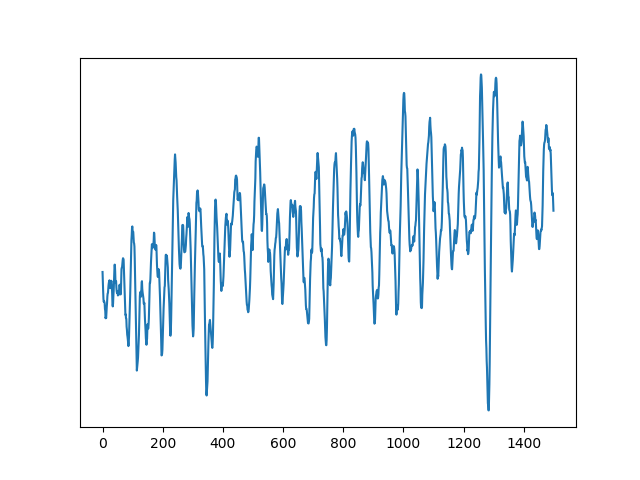

<IPython.core.display.Javascript object>


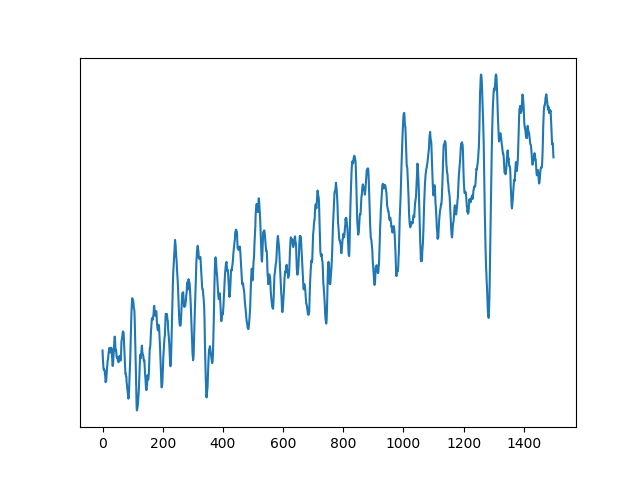

<IPython.core.display.Javascript object>


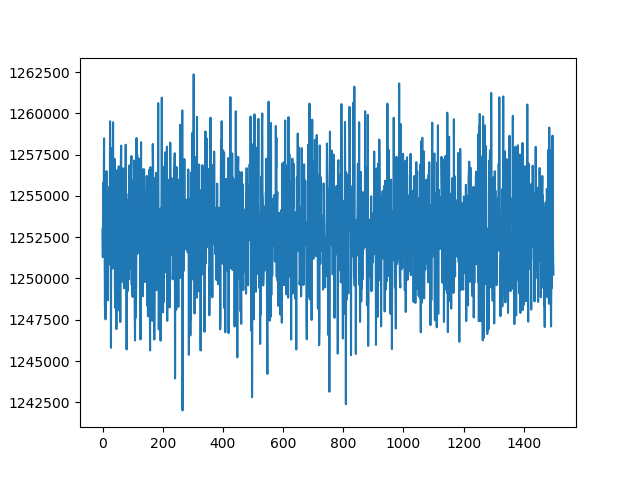

In [39]:

figure()
semilogy(Logger.val_dict['stored_K.K0._lengthscale_storage'][-1500:])
figure()
semilogy(Logger.val_dict['stored_K.K0._amplitude_storage'][-1500:])
figure()
plot(Logger.val_dict['loss'][-1500:])

<IPython.core.display.Javascript object>


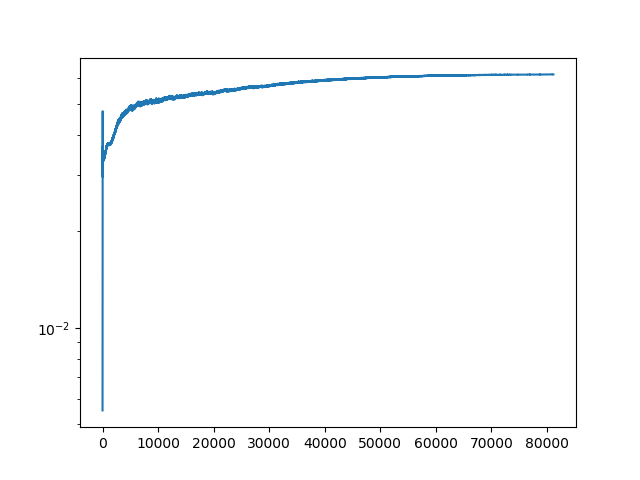

<IPython.core.display.Javascript object>


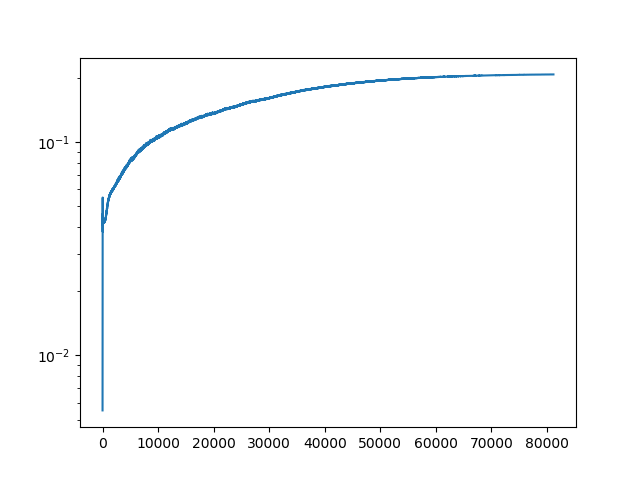

<IPython.core.display.Javascript object>


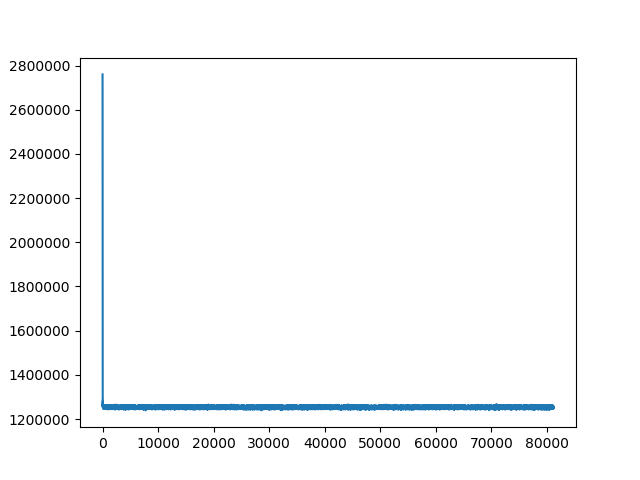

In [40]:

figure()
semilogy(Logger.val_dict['stored_K.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K0._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])

<IPython.core.display.Javascript object>


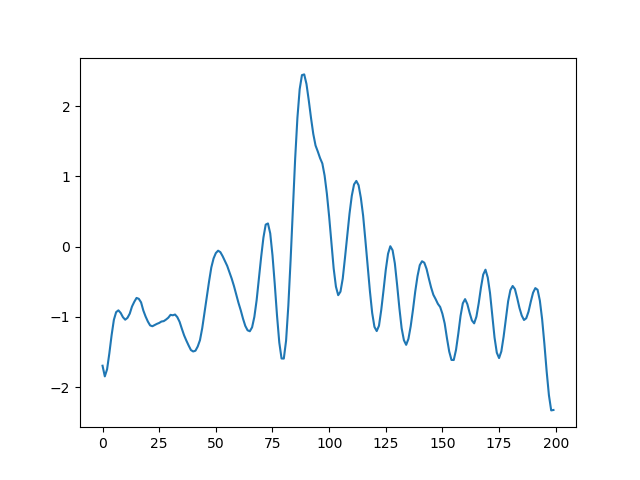

In [20]:
figure()
plot(m.variational_params['m'].detach().numpy())

In [21]:
torch.nn.functional.softplus?

<IPython.core.display.Javascript object>


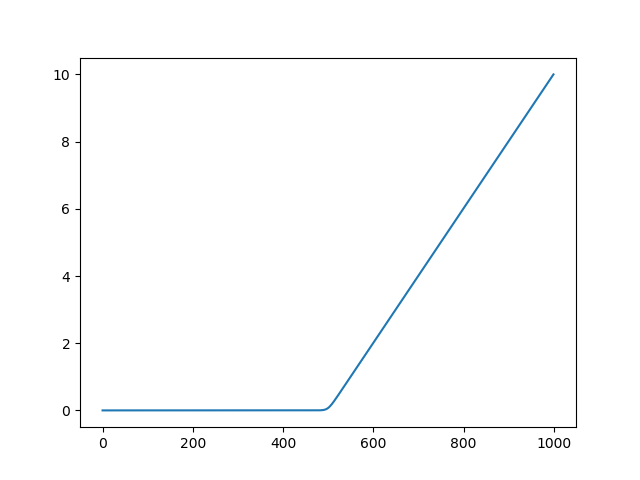

In [23]:
figure()
plot(torch.nn.functional.softplus(torch.linspace(-10,10,1000),beta=10).numpy())

## Example 3

1. RIXS Signal
2. Poisson noise with poisson likelihood
3. Reparameterization gradients
4. ND Titsias parameterization of posterior covariance
5. Full rank (no inducing points)

In [2]:
X, Yc, Y = make_fake_rixs_weighted(1000000, 100, 30, noise_type='Poisson', mean_snr=1.0, sase_bw_factor=1)

In [27]:
#total photons in data set (units of 1 million photons)
Yc[:10000,:].sum()/1E6

0.300859

<IPython.core.display.Javascript object>


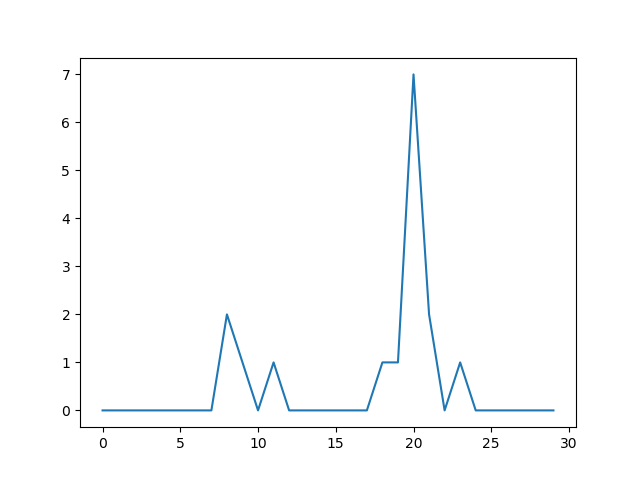

In [11]:
figure()
plot(Yc[0])

In [28]:
class VFE_2D_GPMM_Reparam_FullCov_Poisson(torch.nn.Module):
    def __init__(self, F0, F1, Ntotal, Nmc = 10, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        λ0 = Vector('λ0')
        λ1 = Vector('λ1')
        f0 = Vector('f0')
        f1 = Vector('f1')
        K0 = Kernel('K0')
        K1 = Kernel('K1')
        Y = Vector('Y')
        X = Matrix('X')
        I = Matrix('I')
        Ntotal = Constant(Ntotal)
        Nmc = Constant(Nmc)
        #and finally the standard deviation of the likelihood
#         std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_2D(K0, K1, f0, f1, λ0, λ1, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        mf = mean_2D(K0, K1, f0, f1, f0, f1, m)
        varf0 = var_posterior_fullcov_fullrank(K0, f0, λ0, jitter)
        varf1 = var_posterior_fullcov_fullrank(K1, f1, λ1, jitter)
        varf_diag = KroneckerProduct(ExtractDiagonal(varf0),ExtractDiagonal(varf1))
        stdf0 = CholeskyRoot(AddJitter(varf0,jitter))
        stdf1 = CholeskyRoot(AddJitter(varf1,jitter))
        
        ### write out prediction functions while we're here ###
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        graph = expr2graph(Label(String("var_pred"), varf_diag))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        ### Gaussian Likelihood in f-space ###
        ϵ = StdNormalSample(mf,Nmc)
        zf = KronMVProd(stdf0,stdf1,ϵ) + mf
        z = KronMVProd(I,X,Softhinge(zf,Constant(10.0)))
        y = FVec(Y)
        ve_loss = poisson_likelihood(y, z, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((F0*F1,1),dtype=self.dtype)/(F0*F1)),
                'λ0': torch.nn.Parameter(5*torch.ones((F0,1),dtype=self.dtype)),
                'λ1': torch.nn.Parameter(5*torch.ones((F1,1),dtype=self.dtype)),
            })
            self.hyper_params = torch.nn.ParameterDict({
#                 'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
                'f1': torch.nn.Parameter(torch.linspace(-1,1,F1,dtype=self.dtype).unsqueeze(1), requires_grad=False),
                'I': torch.nn.Parameter(torch.eye(F0,dtype=self.dtype), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]),
                                   transforms=[self._makepos, self._makepos]),
                'K1': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]),
                                   transforms=[self._makepos, self._makepos]),
                })
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, Y, X):
        leaves = {
            'Y': Y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, Y, X):
        leaves = {
            'Y': Y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
#             'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred

In [29]:
#set up the optimization
m = VFE_2D_GPMM_Reparam_FullCov_Poisson(30,100,30*1000000,Nmc=100,lenscale_init=0.1)
optimizer = torch.optim.Adam(m.parameters(),lr=1e-1)
scheduler = StepLR(optimizer,150,gamma=0.92)
epochs = 5000
c = 0
# m.hyper_params['u0'].requires_grad = False
# m.hyper_params['u1'].requires_grad = False
# m.stored_K['K0']._lengthscale_storage.requires_grad = False
# m.stored_K['K0']._amplitude_storage.requires_grad = False
# m.stored_K['K1']._lengthscale_storage.requires_grad = False
# m.stored_K['K1']._amplitude_storage.requires_grad = False

In [59]:
#run it
m.cuda()




data = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(Yc.astype('float32')))
Logger = ScalarLogger(m, {'stored_K.K0._lengthscale_storage': m._makepos,
                          'stored_K.K0._amplitude_storage': m._makepos,
                          'stored_K.K1._lengthscale_storage': m._makepos,
                          'stored_K.K1._amplitude_storage': m._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs - c):
    c += 1
    d = DataLoader(dataset=data, shuffle=True, batch_size=10000)
    for Xb,Yb in d:
        Ybc, Xbc = Yb.cuda(), Xb.cuda()
        optimizer.zero_grad()
        loss = m.loss(Ybc,Xbc)
#         loss = m.loss(Yb,Xb)
        loss.backward()
        optimizer.step()
        Logger(extra_vals=[float(loss), float(optimizer.param_groups[0]['lr'])])
    scheduler.step()
    print(Logger.report("epoch {:d}: ".format(i)))

epoch 0: stored_K.K0._lengthscale_storage: 0.0571751, stored_K.K0._amplitude_storage: 0.458048, stored_K.K1._lengthscale_storage: 0.0576366, stored_K.K1._amplitude_storage: 0.537672, loss: 3.09126e+07, step_size: 0.1, 
epoch 1: stored_K.K0._lengthscale_storage: 0.0571874, stored_K.K0._amplitude_storage: 0.45284, stored_K.K1._lengthscale_storage: 0.0577309, stored_K.K1._amplitude_storage: 0.532296, loss: 3.09568e+07, step_size: 0.1, 
epoch 2: stored_K.K0._lengthscale_storage: 0.0571847, stored_K.K0._amplitude_storage: 0.449049, stored_K.K1._lengthscale_storage: 0.0579123, stored_K.K1._amplitude_storage: 0.528397, loss: 3.09532e+07, step_size: 0.1, 
epoch 3: stored_K.K0._lengthscale_storage: 0.0573278, stored_K.K0._amplitude_storage: 0.446235, stored_K.K1._lengthscale_storage: 0.0579623, stored_K.K1._amplitude_storage: 0.525836, loss: 3.09475e+07, step_size: 0.1, 
epoch 4: stored_K.K0._lengthscale_storage: 0.0575263, stored_K.K0._amplitude_storage: 0.442242, stored_K.K1._lengthscale_stor

epoch 38: stored_K.K0._lengthscale_storage: 0.0583744, stored_K.K0._amplitude_storage: 0.326685, stored_K.K1._lengthscale_storage: 0.0579266, stored_K.K1._amplitude_storage: 0.403968, loss: 3.08287e+07, step_size: 0.1, 
epoch 39: stored_K.K0._lengthscale_storage: 0.0592682, stored_K.K0._amplitude_storage: 0.328629, stored_K.K1._lengthscale_storage: 0.0586259, stored_K.K1._amplitude_storage: 0.406849, loss: 3.10301e+07, step_size: 0.1, 
epoch 40: stored_K.K0._lengthscale_storage: 0.0584656, stored_K.K0._amplitude_storage: 0.321739, stored_K.K1._lengthscale_storage: 0.0577769, stored_K.K1._amplitude_storage: 0.399254, loss: 3.09934e+07, step_size: 0.1, 
epoch 41: stored_K.K0._lengthscale_storage: 0.0587783, stored_K.K0._amplitude_storage: 0.319964, stored_K.K1._lengthscale_storage: 0.0580691, stored_K.K1._amplitude_storage: 0.397479, loss: 3.0811e+07, step_size: 0.1, 
epoch 42: stored_K.K0._lengthscale_storage: 0.0589247, stored_K.K0._amplitude_storage: 0.318265, stored_K.K1._lengthscale

epoch 76: stored_K.K0._lengthscale_storage: 0.0612838, stored_K.K0._amplitude_storage: 0.255217, stored_K.K1._lengthscale_storage: 0.0601211, stored_K.K1._amplitude_storage: 0.331382, loss: 3.10078e+07, step_size: 0.1, 
epoch 77: stored_K.K0._lengthscale_storage: 0.0609312, stored_K.K0._amplitude_storage: 0.251588, stored_K.K1._lengthscale_storage: 0.0594775, stored_K.K1._amplitude_storage: 0.327147, loss: 3.10482e+07, step_size: 0.1, 
epoch 78: stored_K.K0._lengthscale_storage: 0.0614505, stored_K.K0._amplitude_storage: 0.251149, stored_K.K1._lengthscale_storage: 0.0596364, stored_K.K1._amplitude_storage: 0.327053, loss: 3.09764e+07, step_size: 0.1, 
epoch 79: stored_K.K0._lengthscale_storage: 0.0614353, stored_K.K0._amplitude_storage: 0.25109, stored_K.K1._lengthscale_storage: 0.0599248, stored_K.K1._amplitude_storage: 0.327509, loss: 3.09638e+07, step_size: 0.1, 
epoch 80: stored_K.K0._lengthscale_storage: 0.0614876, stored_K.K0._amplitude_storage: 0.249811, stored_K.K1._lengthscale

epoch 114: stored_K.K0._lengthscale_storage: 0.0640133, stored_K.K0._amplitude_storage: 0.2263, stored_K.K1._lengthscale_storage: 0.0630643, stored_K.K1._amplitude_storage: 0.306799, loss: 3.10045e+07, step_size: 0.092, 
epoch 115: stored_K.K0._lengthscale_storage: 0.0641991, stored_K.K0._amplitude_storage: 0.225948, stored_K.K1._lengthscale_storage: 0.0630251, stored_K.K1._amplitude_storage: 0.306672, loss: 3.09174e+07, step_size: 0.092, 
epoch 116: stored_K.K0._lengthscale_storage: 0.0640408, stored_K.K0._amplitude_storage: 0.224867, stored_K.K1._lengthscale_storage: 0.0629372, stored_K.K1._amplitude_storage: 0.305511, loss: 3.10238e+07, step_size: 0.092, 
epoch 117: stored_K.K0._lengthscale_storage: 0.063748, stored_K.K0._amplitude_storage: 0.224556, stored_K.K1._lengthscale_storage: 0.0629669, stored_K.K1._amplitude_storage: 0.305435, loss: 3.09518e+07, step_size: 0.092, 
epoch 118: stored_K.K0._lengthscale_storage: 0.063931, stored_K.K0._amplitude_storage: 0.223782, stored_K.K1._l

epoch 151: stored_K.K0._lengthscale_storage: 0.065382, stored_K.K0._amplitude_storage: 0.211306, stored_K.K1._lengthscale_storage: 0.0644691, stored_K.K1._amplitude_storage: 0.298199, loss: 3.09061e+07, step_size: 0.092, 
epoch 152: stored_K.K0._lengthscale_storage: 0.0648609, stored_K.K0._amplitude_storage: 0.209467, stored_K.K1._lengthscale_storage: 0.0638859, stored_K.K1._amplitude_storage: 0.296214, loss: 3.09084e+07, step_size: 0.092, 
epoch 153: stored_K.K0._lengthscale_storage: 0.065723, stored_K.K0._amplitude_storage: 0.211429, stored_K.K1._lengthscale_storage: 0.0646781, stored_K.K1._amplitude_storage: 0.299186, loss: 3.09491e+07, step_size: 0.092, 
epoch 154: stored_K.K0._lengthscale_storage: 0.0651928, stored_K.K0._amplitude_storage: 0.21125, stored_K.K1._lengthscale_storage: 0.0649203, stored_K.K1._amplitude_storage: 0.29915, loss: 3.08446e+07, step_size: 0.092, 
epoch 155: stored_K.K0._lengthscale_storage: 0.0650062, stored_K.K0._amplitude_storage: 0.2089, stored_K.K1._len

epoch 188: stored_K.K0._lengthscale_storage: 0.0662483, stored_K.K0._amplitude_storage: 0.202657, stored_K.K1._lengthscale_storage: 0.0659694, stored_K.K1._amplitude_storage: 0.298331, loss: 3.08829e+07, step_size: 0.092, 
epoch 189: stored_K.K0._lengthscale_storage: 0.0664346, stored_K.K0._amplitude_storage: 0.203045, stored_K.K1._lengthscale_storage: 0.0661917, stored_K.K1._amplitude_storage: 0.299163, loss: 3.09067e+07, step_size: 0.092, 
epoch 190: stored_K.K0._lengthscale_storage: 0.0663421, stored_K.K0._amplitude_storage: 0.20203, stored_K.K1._lengthscale_storage: 0.0659548, stored_K.K1._amplitude_storage: 0.298048, loss: 3.09309e+07, step_size: 0.092, 
epoch 191: stored_K.K0._lengthscale_storage: 0.0660623, stored_K.K0._amplitude_storage: 0.202309, stored_K.K1._lengthscale_storage: 0.0660548, stored_K.K1._amplitude_storage: 0.298927, loss: 3.09891e+07, step_size: 0.092, 
epoch 192: stored_K.K0._lengthscale_storage: 0.0660208, stored_K.K0._amplitude_storage: 0.20113, stored_K.K1.

epoch 225: stored_K.K0._lengthscale_storage: 0.0669387, stored_K.K0._amplitude_storage: 0.195808, stored_K.K1._lengthscale_storage: 0.0668797, stored_K.K1._amplitude_storage: 0.301586, loss: 3.09741e+07, step_size: 0.092, 
epoch 226: stored_K.K0._lengthscale_storage: 0.0673156, stored_K.K0._amplitude_storage: 0.196209, stored_K.K1._lengthscale_storage: 0.067161, stored_K.K1._amplitude_storage: 0.302436, loss: 3.08082e+07, step_size: 0.092, 


KeyboardInterrupt: 

In [60]:
m.cpu()

VFE_2D_GPMM_Reparam_FullCov_Poisson(
  (variational_params): ParameterDict(
      (m): Parameter containing: [torch.FloatTensor of size 3000x1]
      (λ0): Parameter containing: [torch.FloatTensor of size 30x1]
      (λ1): Parameter containing: [torch.FloatTensor of size 100x1]
  )
  (hyper_params): ParameterDict(
      (I): Parameter containing: [torch.FloatTensor of size 30x30]
      (f0): Parameter containing: [torch.FloatTensor of size 30x1]
      (f1): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0667]]), amplitude=0.19561059772968292)
    (K1): ARDRBFKernel(lengthscale=tensor([[0.0669]]), amplitude=0.3018066883087158)
  )
)

<IPython.core.display.Javascript object>


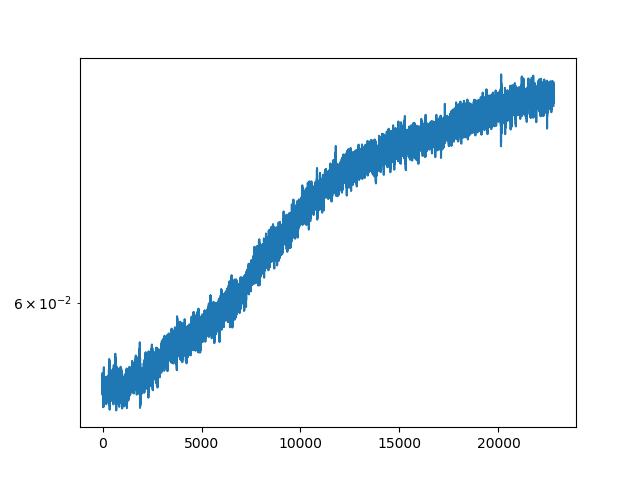

<IPython.core.display.Javascript object>


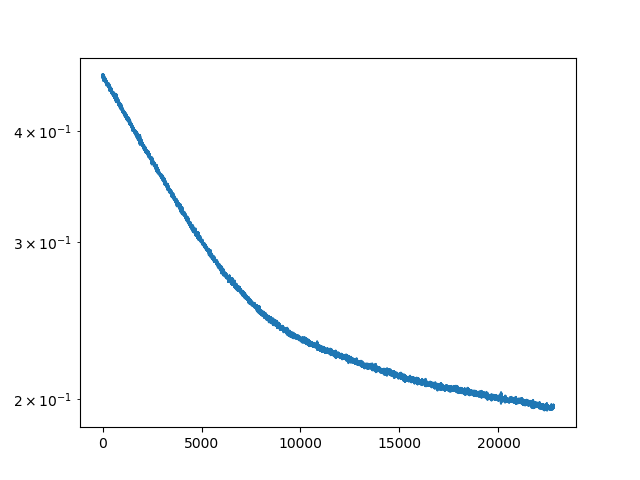

<IPython.core.display.Javascript object>


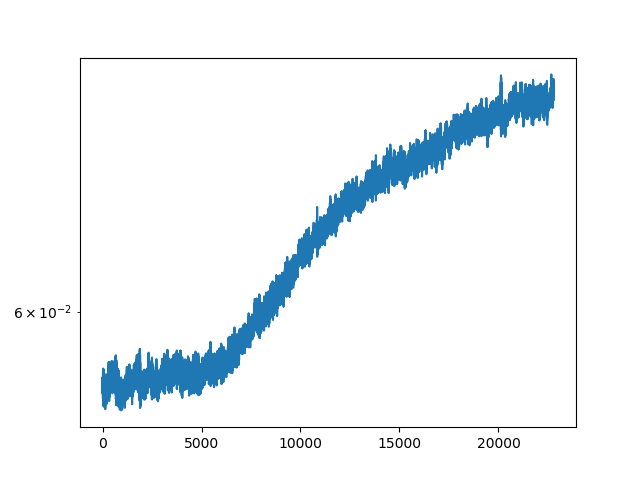

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


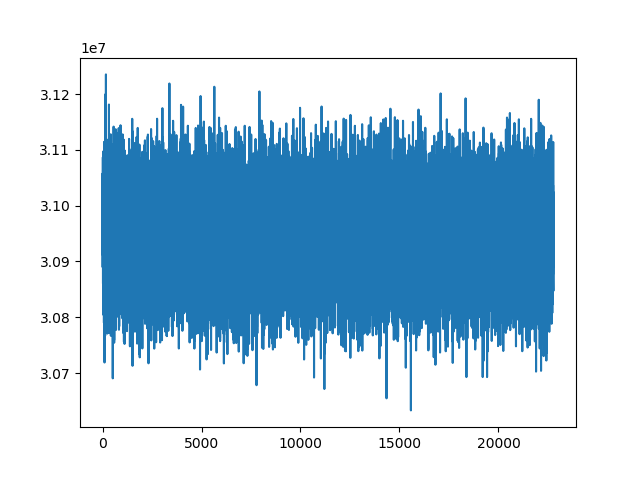

In [61]:
figure()
semilogy(Logger.val_dict['stored_K.K0._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K0._amplitude_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._lengthscale_storage'])
figure()
semilogy(Logger.val_dict['stored_K.K1._amplitude_storage'])
figure()
plot(Logger.val_dict['loss'])

In [62]:
def makepos(T):
    return torch.nn.functional.softplus(T.detach(),beta=10.0).numpy()

<IPython.core.display.Javascript object>


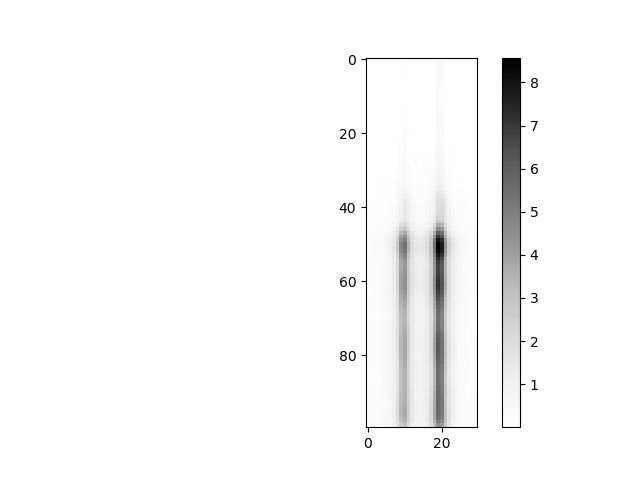

In [63]:
figure()
μ = m.predict_mean().reshape(30,100).t()
imshow(makepos(μ),cmap=matplotlib.cm.Greys)
colorbar()

In [64]:
figure()
μ = m.predict_mean().reshape(30,100).t()[:,19]
σ = m.predict_var().reshape(30,100).t()[:,19]
plot(makepos(μ), label='estimated')
fill_between(np.arange(100),makepos(μ+σ),makepos(μ-σ),color='k',alpha=0.5,label='est error')
plot(Y[:,19],label='ground truth')
legend()

<IPython.core.display.Javascript object>

In [65]:
figure()
μ = m.predict_mean().reshape(30,100).t()[:,9]
σ = m.predict_var().reshape(30,100).t()[:,9]
plot(makepos(μ), label='estimated')
fill_between(np.arange(100),makepos(μ+σ),makepos(μ-σ),color='k',alpha=0.5,label='est error')
plot(Y[:,9],label='ground truth')
legend()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


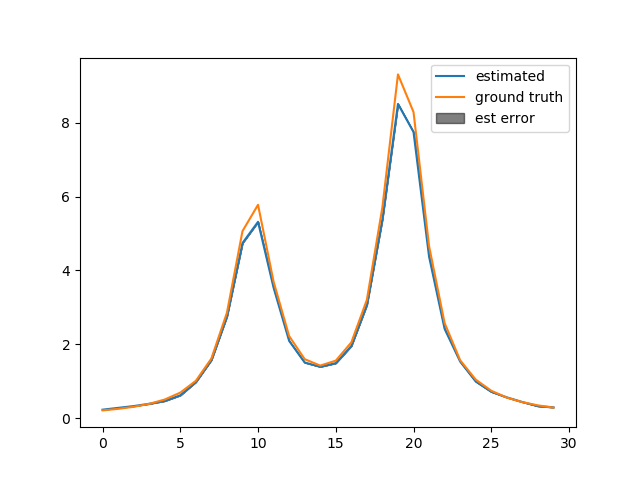

In [66]:
figure()
μ = m.predict_mean().reshape(30,100).t()[50,:]
σ = m.predict_var().reshape(30,100).t()[50,:]
plot(makepos(μ), label='estimated')
fill_between(np.arange(30),makepos(μ+σ),makepos(μ-σ),color='k',alpha=0.5,label='est error')
plot(Y[50,:],label='ground truth')
legend()

In [51]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    register_cmap(cmap=newcmap)

    return newcmap

<IPython.core.display.Javascript object>


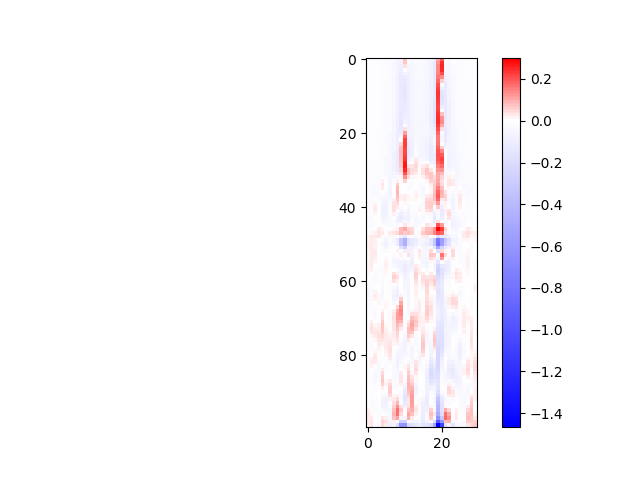

In [70]:
cmap = shiftedColorMap(matplotlib.cm.bwr,midpoint=0.835)
figure()
μ = m.predict_mean().reshape(30,100).t()
imshow(makepos(μ) - Y,cmap=cmap)
colorbar()

In [71]:
class VFE_2D_GPMM_Gaussian(torch.nn.Module):
    def __init__(self, U0, U1, F0, F1, Ntotal, std_lik_init = 0.5, lenscale_init = 0.05,
                 dtype=torch.get_default_dtype()):
        super().__init__()
        self.dtype = dtype
        m = Vector('m')
        λ0 = Vector('λ0')
        λ1 = Vector('λ1')
        u0 = Vector('u0')
        u1 = Vector('u1')
        f0 = Vector('f0')
        f1 = Vector('f1')
        K0 = Kernel('K0')
        K1 = Kernel('K1')
        Y = Vector('Y')
        X = Matrix('X')
        Ntotal = Constant(Ntotal)
        #and finally the standard deviation of the likelihood
        std_lik = Scalar('std_lik')
        jitter = Scalar('jitter')
        #generally there are parameters which require positivity. I use this transform for them:
        self._makepos = SoftplusTransform()
        
        ### KL loss graph ###
        kl_loss = kl_2D(K0, K1, u0, u1, λ0, λ1, m, jitter)
        self._kl_loss_expr = kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to weighted f-space ###
        K0_fu = EvaluateKernel(K0, f0, u0)
        K1_fu = EvaluateKernel(K1, f1, u1)
        mf = KronMVProd(K0_fu, X @ K1_fu, m)
        
        t1 = KroneckerProduct(var_fullspace_diag(K0, f0), weighted_var_fullspace_diag(K1, f1, X))
        t2 = KroneckerProduct(var_subspace_diag(K0, u0, f0, jitter), weighted_var_subspace_diag(K1, u1, f1, X, jitter))
        t3 = KroneckerProduct(var_posterior_diag(K0, u0, f0, λ0, jitter), weighted_var_posterior_diag(K1, u1, f1, λ1, X, jitter))
        varf = t1 - t2 + t3
        
        ### Gaussian Likelihood in f-space ###
        #use FVec here because Y is ordered with output dim last, when I want it first
        #in order to match my notes.
        #note: we don't reorder Y, because we want batch dim (0th dim) to be shot dim
        #it's just a convention thing, don't think too hard about it
        y = FVec(Y) 
        ve_loss = analytic_gaussian_likelihood(y, mf, varf, std_lik, Ntotal)
        self._ve_loss_expr = ve_loss
        graph = expr2graph(Label(String("ve_loss"), ve_loss))
        self._ve_loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        #form the total loss
        loss = -ve_loss + kl_loss
        graph = expr2graph(Label(String("loss"), loss))
        self._loss_fun = graph2ast(graph, compiled=True, debug=False)
        
        ### Predict to f-space ###
        mf = mean_2D(K0, K1, u0, u1, f0, f1, m)
        graph = expr2graph(Label(String("mean_pred"), mf))
        self._mean_pred = graph2ast(graph, compiled=True, debug=False)
        t1 = KroneckerProduct(var_fullspace_diag(K0, f0), var_fullspace_diag(K1, f1))
        t2 = KroneckerProduct(var_subspace_diag(K0, u0, f0, jitter), var_subspace_diag(K1, u1, f1, jitter))
        t3 = KroneckerProduct(var_posterior_diag(K0, u0, f0, λ0, jitter), var_posterior_diag(K1, u1, f1, λ1, jitter))
        varf = t1 - t2 + t3
        graph = expr2graph(Label(String("var_pred"), varf))
        self._var_pred = graph2ast(graph, compiled=True, debug=False)
        
        
        #the actual storage tensors go here:
        with torch.no_grad():
            self.variational_params = torch.nn.ParameterDict({
                'm': torch.nn.Parameter(torch.randn((U0*U1,1),dtype=self.dtype)/(U0*U1)),
                'λ0': torch.nn.Parameter(5*torch.ones((U0,1),dtype=self.dtype)),
                'λ1': torch.nn.Parameter(5*torch.ones((U1,1),dtype=self.dtype)),
            })
            self.hyper_params = torch.nn.ParameterDict({
                'std_lik': torch.nn.Parameter(self._makepos.inv(torch.tensor([[std_lik_init]],dtype=self.dtype))),
                'u0': torch.nn.Parameter(torch.linspace(-1,1,U0,dtype=self.dtype).unsqueeze(1)),
                'u1': torch.nn.Parameter(torch.linspace(-1,1,U1,dtype=self.dtype).unsqueeze(1)),
                #fixed parameters go here:
                'jitter': torch.nn.Parameter(torch.tensor(1.0e-4,dtype=self.dtype), requires_grad=False),
                'f0': torch.nn.Parameter(torch.linspace(-1,1,F0,dtype=self.dtype).unsqueeze(1), requires_grad=False),
                'f1': torch.nn.Parameter(torch.linspace(-1,1,F1,dtype=self.dtype).unsqueeze(1), requires_grad=False),
            })

            #modules containing parameters go here:
            self.stored_K = torch.nn.ModuleDict({
                'K0': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                'K1': ARDRBFKernel(lengthscale=torch.tensor([[lenscale_init]]), transforms=[self._makepos, self._makepos]),
                })
    def kl_loss(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
        }
        result = self._kl_loss_fun(**leaves)
        return result.kl_loss
    def ve_loss(self, Y, X):
        leaves = {
            'Y': Y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._ve_loss_fun(**leaves)
        return result.ve_loss
    def loss(self, Y, X):
        leaves = {
            'Y': Y,
            'X': X,
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._loss_fun(**leaves)
        return result.loss
    def predict_mean(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._mean_pred(**leaves)
        return result.mean_pred
    def predict_var(self):
        leaves = {
            **self.variational_params,
            **self.hyper_params,
            **self.stored_K,
            'λ0': self._makepos(self.variational_params['λ0']),
            'λ1': self._makepos(self.variational_params['λ1']),
            'std_lik': self._makepos(self.hyper_params['std_lik'])
        }
        result = self._var_pred(**leaves)
        return result.var_pred

In [77]:
#set up the optimization
m2 = VFE_2D_GPMM_Gaussian(25,75,30,100,30*1000000,lenscale_init=0.05,std_lik_init=1.0)
optimizer2 = torch.optim.Adam(m2.parameters(),lr=1e-1)
scheduler2 = StepLR(optimizer2,150,gamma=0.92)
epochs2 = 275
c2 = 0
# m.hyper_params['u0'].requires_grad = False
# m.hyper_params['u1'].requires_grad = False
# m.stored_K['K0']._lengthscale_storage.requires_grad = False
# m2.stored_K['K0']._amplitude_storage.requires_grad = False
# m.stored_K['K1']._lengthscale_storage.requires_grad = False
# m2.stored_K['K1']._amplitude_storage.requires_grad = False

In [78]:
#run it
m2.cuda()




data2 = TensorDataset(torch.from_numpy(X.astype('float32')), torch.from_numpy(Yc.astype('float32'))/Yc.mean())
Logger2 = ScalarLogger(m2, {'hyper_params.std_lik': m2._makepos,
                          'stored_K.K0._lengthscale_storage': m2._makepos,
                          'stored_K.K0._amplitude_storage': m2._makepos,
                          'stored_K.K1._lengthscale_storage': m2._makepos,
                          'stored_K.K1._amplitude_storage': m2._makepos},
                     extra_keys={'loss': lambda x: x,
                                'step_size': lambda x: x})

for i in range(epochs2 - c2):
    c += 1
    d = DataLoader(dataset=data2, shuffle=True, batch_size=10000)
    for Xb,Yb in d:
        Ybc, Xbc = Yb.cuda(), Xb.cuda()
        optimizer2.zero_grad()
        loss = m2.loss(Ybc,Xbc)
#         loss = m.loss(Yb,Xb)
        loss.backward()
        optimizer2.step()
        Logger2(extra_vals=[float(loss.item()), float(optimizer2.param_groups[0]['lr'])])
    scheduler2.step()
    print(Logger2.report("epoch {:d}: ".format(i)))

epoch 0: hyper_params.std_lik: 1.00925, stored_K.K0._lengthscale_storage: 0.0877946, stored_K.K0._amplitude_storage: 0.697635, stored_K.K1._lengthscale_storage: 0.0355879, stored_K.K1._amplitude_storage: 0.713278, loss: 4.28451e+07, step_size: 0.1, 
epoch 1: hyper_params.std_lik: 1.00273, stored_K.K0._lengthscale_storage: 0.0853635, stored_K.K0._amplitude_storage: 0.652152, stored_K.K1._lengthscale_storage: 0.0414838, stored_K.K1._amplitude_storage: 0.667344, loss: 4.2463e+07, step_size: 0.1, 
epoch 2: hyper_params.std_lik: 1.00301, stored_K.K0._lengthscale_storage: 0.0858031, stored_K.K0._amplitude_storage: 0.614845, stored_K.K1._lengthscale_storage: 0.0449129, stored_K.K1._amplitude_storage: 0.628799, loss: 4.26999e+07, step_size: 0.1, 
epoch 3: hyper_params.std_lik: 1.00075, stored_K.K0._lengthscale_storage: 0.0855412, stored_K.K0._amplitude_storage: 0.581967, stored_K.K1._lengthscale_storage: 0.0481154, stored_K.K1._amplitude_storage: 0.594186, loss: 4.26195e+07, step_size: 0.1, 
e

epoch 33: hyper_params.std_lik: 1.00289, stored_K.K0._lengthscale_storage: 0.0851637, stored_K.K0._amplitude_storage: 0.283566, stored_K.K1._lengthscale_storage: 0.0884117, stored_K.K1._amplitude_storage: 0.25388, loss: 4.2669e+07, step_size: 0.1, 
epoch 34: hyper_params.std_lik: 0.993762, stored_K.K0._lengthscale_storage: 0.0824349, stored_K.K0._amplitude_storage: 0.280081, stored_K.K1._lengthscale_storage: 0.0885992, stored_K.K1._amplitude_storage: 0.2498, loss: 4.27935e+07, step_size: 0.1, 
epoch 35: hyper_params.std_lik: 1.01162, stored_K.K0._lengthscale_storage: 0.0823086, stored_K.K0._amplitude_storage: 0.275239, stored_K.K1._lengthscale_storage: 0.0887743, stored_K.K1._amplitude_storage: 0.244662, loss: 4.26374e+07, step_size: 0.1, 
epoch 36: hyper_params.std_lik: 1.00213, stored_K.K0._lengthscale_storage: 0.0841508, stored_K.K0._amplitude_storage: 0.272823, stored_K.K1._lengthscale_storage: 0.0889428, stored_K.K1._amplitude_storage: 0.241708, loss: 4.28519e+07, step_size: 0.1, 

epoch 66: hyper_params.std_lik: 1.01192, stored_K.K0._lengthscale_storage: 0.0826044, stored_K.K0._amplitude_storage: 0.224361, stored_K.K1._lengthscale_storage: 0.0924772, stored_K.K1._amplitude_storage: 0.182604, loss: 4.27746e+07, step_size: 0.1, 
epoch 67: hyper_params.std_lik: 0.999211, stored_K.K0._lengthscale_storage: 0.0819171, stored_K.K0._amplitude_storage: 0.22117, stored_K.K1._lengthscale_storage: 0.0924356, stored_K.K1._amplitude_storage: 0.179562, loss: 4.25893e+07, step_size: 0.1, 
epoch 68: hyper_params.std_lik: 1.00058, stored_K.K0._lengthscale_storage: 0.0811792, stored_K.K0._amplitude_storage: 0.220684, stored_K.K1._lengthscale_storage: 0.0938128, stored_K.K1._amplitude_storage: 0.178755, loss: 4.26426e+07, step_size: 0.1, 
epoch 69: hyper_params.std_lik: 1.0058, stored_K.K0._lengthscale_storage: 0.0825595, stored_K.K0._amplitude_storage: 0.220522, stored_K.K1._lengthscale_storage: 0.0936291, stored_K.K1._amplitude_storage: 0.178094, loss: 4.26119e+07, step_size: 0.1

epoch 99: hyper_params.std_lik: 1.00848, stored_K.K0._lengthscale_storage: 0.0807145, stored_K.K0._amplitude_storage: 0.207443, stored_K.K1._lengthscale_storage: 0.0936283, stored_K.K1._amplitude_storage: 0.157132, loss: 4.26411e+07, step_size: 0.1, 
epoch 100: hyper_params.std_lik: 1.01231, stored_K.K0._lengthscale_storage: 0.081991, stored_K.K0._amplitude_storage: 0.203284, stored_K.K1._lengthscale_storage: 0.0920046, stored_K.K1._amplitude_storage: 0.153575, loss: 4.30514e+07, step_size: 0.1, 
epoch 101: hyper_params.std_lik: 1.01042, stored_K.K0._lengthscale_storage: 0.0831718, stored_K.K0._amplitude_storage: 0.20723, stored_K.K1._lengthscale_storage: 0.0920519, stored_K.K1._amplitude_storage: 0.156339, loss: 4.30507e+07, step_size: 0.1, 
epoch 102: hyper_params.std_lik: 0.992408, stored_K.K0._lengthscale_storage: 0.0824305, stored_K.K0._amplitude_storage: 0.20697, stored_K.K1._lengthscale_storage: 0.0911129, stored_K.K1._amplitude_storage: 0.155859, loss: 4.22152e+07, step_size: 0

epoch 132: hyper_params.std_lik: 1.0075, stored_K.K0._lengthscale_storage: 0.0822822, stored_K.K0._amplitude_storage: 0.201905, stored_K.K1._lengthscale_storage: 0.09476, stored_K.K1._amplitude_storage: 0.142975, loss: 4.25284e+07, step_size: 0.1, 
epoch 133: hyper_params.std_lik: 0.995162, stored_K.K0._lengthscale_storage: 0.0809901, stored_K.K0._amplitude_storage: 0.203021, stored_K.K1._lengthscale_storage: 0.0942844, stored_K.K1._amplitude_storage: 0.14352, loss: 4.27166e+07, step_size: 0.1, 
epoch 134: hyper_params.std_lik: 0.994082, stored_K.K0._lengthscale_storage: 0.0792965, stored_K.K0._amplitude_storage: 0.203143, stored_K.K1._lengthscale_storage: 0.0948521, stored_K.K1._amplitude_storage: 0.143305, loss: 4.25334e+07, step_size: 0.1, 
epoch 135: hyper_params.std_lik: 1.01548, stored_K.K0._lengthscale_storage: 0.0795572, stored_K.K0._amplitude_storage: 0.203008, stored_K.K1._lengthscale_storage: 0.0957001, stored_K.K1._amplitude_storage: 0.142934, loss: 4.26332e+07, step_size: 

epoch 165: hyper_params.std_lik: 1.00329, stored_K.K0._lengthscale_storage: 0.080866, stored_K.K0._amplitude_storage: 0.207405, stored_K.K1._lengthscale_storage: 0.0927353, stored_K.K1._amplitude_storage: 0.138199, loss: 4.25269e+07, step_size: 0.092, 
epoch 166: hyper_params.std_lik: 0.989995, stored_K.K0._lengthscale_storage: 0.0795074, stored_K.K0._amplitude_storage: 0.208803, stored_K.K1._lengthscale_storage: 0.0931699, stored_K.K1._amplitude_storage: 0.138963, loss: 4.25053e+07, step_size: 0.092, 
epoch 167: hyper_params.std_lik: 1.00369, stored_K.K0._lengthscale_storage: 0.0809465, stored_K.K0._amplitude_storage: 0.205296, stored_K.K1._lengthscale_storage: 0.0924125, stored_K.K1._amplitude_storage: 0.136256, loss: 4.26084e+07, step_size: 0.092, 
epoch 168: hyper_params.std_lik: 0.997173, stored_K.K0._lengthscale_storage: 0.0800889, stored_K.K0._amplitude_storage: 0.208226, stored_K.K1._lengthscale_storage: 0.0931424, stored_K.K1._amplitude_storage: 0.137963, loss: 4.25254e+07, st

epoch 198: hyper_params.std_lik: 1.00065, stored_K.K0._lengthscale_storage: 0.0800548, stored_K.K0._amplitude_storage: 0.212532, stored_K.K1._lengthscale_storage: 0.0930836, stored_K.K1._amplitude_storage: 0.133842, loss: 4.27516e+07, step_size: 0.092, 
epoch 199: hyper_params.std_lik: 1.01716, stored_K.K0._lengthscale_storage: 0.0803094, stored_K.K0._amplitude_storage: 0.213139, stored_K.K1._lengthscale_storage: 0.0943473, stored_K.K1._amplitude_storage: 0.13403, loss: 4.27412e+07, step_size: 0.092, 
epoch 200: hyper_params.std_lik: 0.998917, stored_K.K0._lengthscale_storage: 0.0799491, stored_K.K0._amplitude_storage: 0.212505, stored_K.K1._lengthscale_storage: 0.0943161, stored_K.K1._amplitude_storage: 0.133384, loss: 4.25667e+07, step_size: 0.092, 
epoch 201: hyper_params.std_lik: 0.986545, stored_K.K0._lengthscale_storage: 0.0795615, stored_K.K0._amplitude_storage: 0.213207, stored_K.K1._lengthscale_storage: 0.0940211, stored_K.K1._amplitude_storage: 0.133681, loss: 4.2618e+07, ste

epoch 231: hyper_params.std_lik: 1.00154, stored_K.K0._lengthscale_storage: 0.0802399, stored_K.K0._amplitude_storage: 0.217134, stored_K.K1._lengthscale_storage: 0.0947023, stored_K.K1._amplitude_storage: 0.129261, loss: 4.26411e+07, step_size: 0.092, 
epoch 232: hyper_params.std_lik: 1.00277, stored_K.K0._lengthscale_storage: 0.0788022, stored_K.K0._amplitude_storage: 0.216103, stored_K.K1._lengthscale_storage: 0.0937678, stored_K.K1._amplitude_storage: 0.128394, loss: 4.24751e+07, step_size: 0.092, 
epoch 233: hyper_params.std_lik: 1.02471, stored_K.K0._lengthscale_storage: 0.0781045, stored_K.K0._amplitude_storage: 0.215242, stored_K.K1._lengthscale_storage: 0.0955326, stored_K.K1._amplitude_storage: 0.127557, loss: 4.27749e+07, step_size: 0.092, 
epoch 234: hyper_params.std_lik: 0.986704, stored_K.K0._lengthscale_storage: 0.080713, stored_K.K0._amplitude_storage: 0.212272, stored_K.K1._lengthscale_storage: 0.0948435, stored_K.K1._amplitude_storage: 0.125439, loss: 4.26649e+07, ste

epoch 264: hyper_params.std_lik: 0.992049, stored_K.K0._lengthscale_storage: 0.0804148, stored_K.K0._amplitude_storage: 0.223156, stored_K.K1._lengthscale_storage: 0.0949598, stored_K.K1._amplitude_storage: 0.123986, loss: 4.25648e+07, step_size: 0.092, 
epoch 265: hyper_params.std_lik: 0.99733, stored_K.K0._lengthscale_storage: 0.079481, stored_K.K0._amplitude_storage: 0.222954, stored_K.K1._lengthscale_storage: 0.0944001, stored_K.K1._amplitude_storage: 0.12366, loss: 4.26137e+07, step_size: 0.092, 
epoch 266: hyper_params.std_lik: 1.00004, stored_K.K0._lengthscale_storage: 0.0801589, stored_K.K0._amplitude_storage: 0.2229, stored_K.K1._lengthscale_storage: 0.093944, stored_K.K1._amplitude_storage: 0.123294, loss: 4.26858e+07, step_size: 0.092, 
epoch 267: hyper_params.std_lik: 0.995425, stored_K.K0._lengthscale_storage: 0.079421, stored_K.K0._amplitude_storage: 0.223287, stored_K.K1._lengthscale_storage: 0.0935375, stored_K.K1._amplitude_storage: 0.123323, loss: 4.23496e+07, step_si

In [79]:
m2.cpu()

VFE_2D_GPMM_Gaussian(
  (variational_params): ParameterDict(
      (m): Parameter containing: [torch.FloatTensor of size 1875x1]
      (λ0): Parameter containing: [torch.FloatTensor of size 25x1]
      (λ1): Parameter containing: [torch.FloatTensor of size 75x1]
  )
  (hyper_params): ParameterDict(
      (f0): Parameter containing: [torch.FloatTensor of size 30x1]
      (f1): Parameter containing: [torch.FloatTensor of size 100x1]
      (jitter): Parameter containing: [torch.FloatTensor of size ]
      (std_lik): Parameter containing: [torch.FloatTensor of size 1x1]
      (u0): Parameter containing: [torch.FloatTensor of size 25x1]
      (u1): Parameter containing: [torch.FloatTensor of size 75x1]
  )
  (stored_K): ModuleDict(
    (K0): ARDRBFKernel(lengthscale=tensor([[0.0790]]), amplitude=0.22543832659721375)
    (K1): ARDRBFKernel(lengthscale=tensor([[0.0931]]), amplitude=0.12261874973773956)
  )
)

<IPython.core.display.Javascript object>


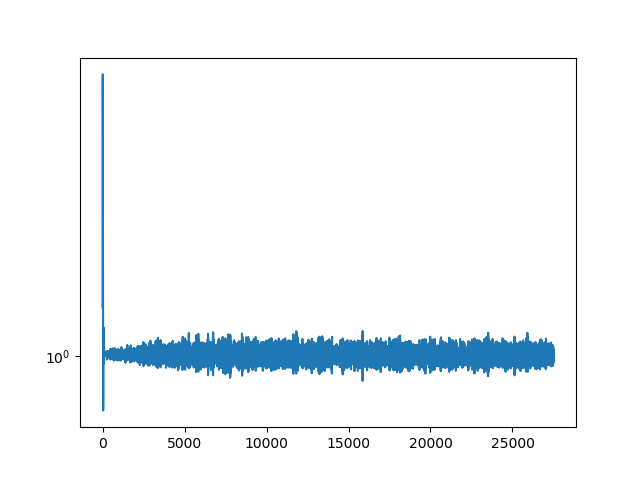

<IPython.core.display.Javascript object>


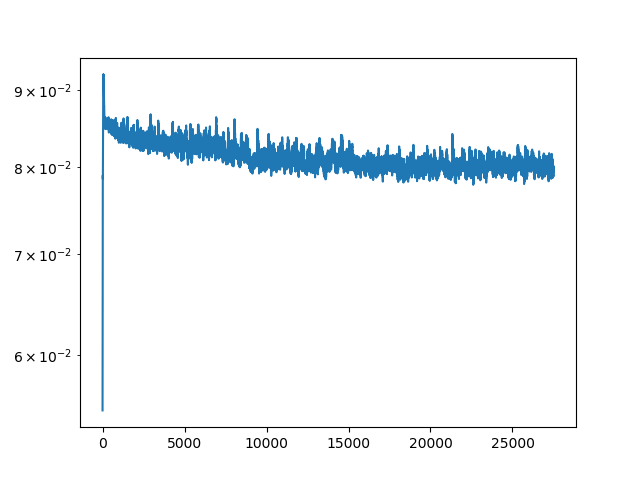

<IPython.core.display.Javascript object>


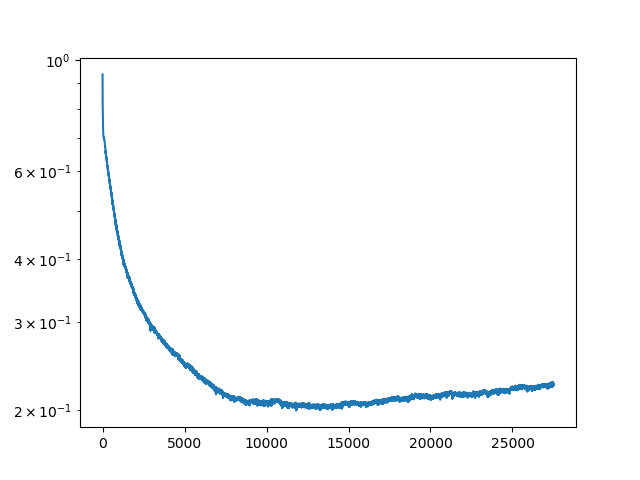

<IPython.core.display.Javascript object>


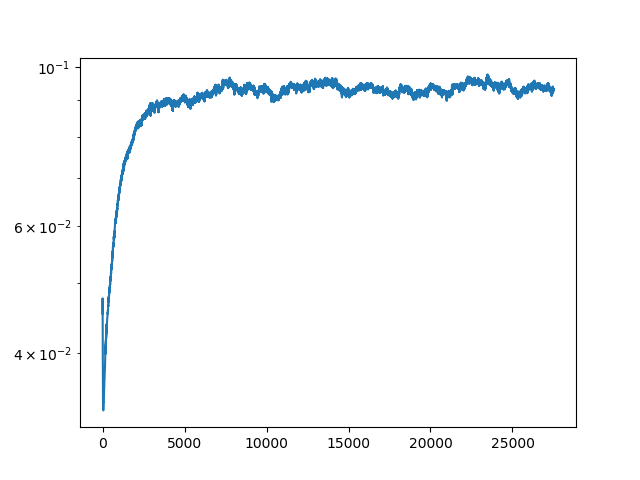

<IPython.core.display.Javascript object>


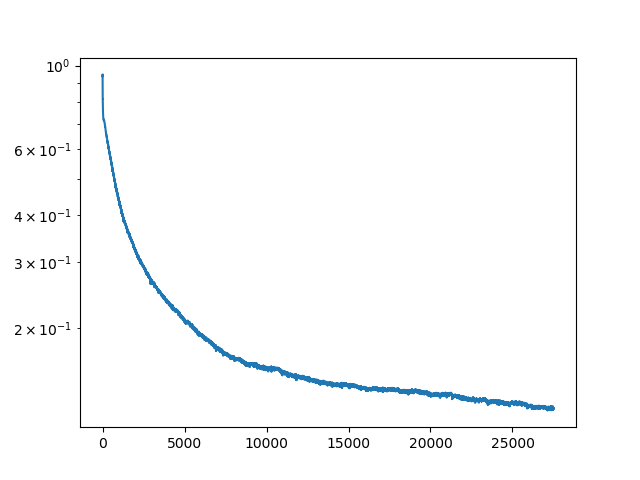

<IPython.core.display.Javascript object>


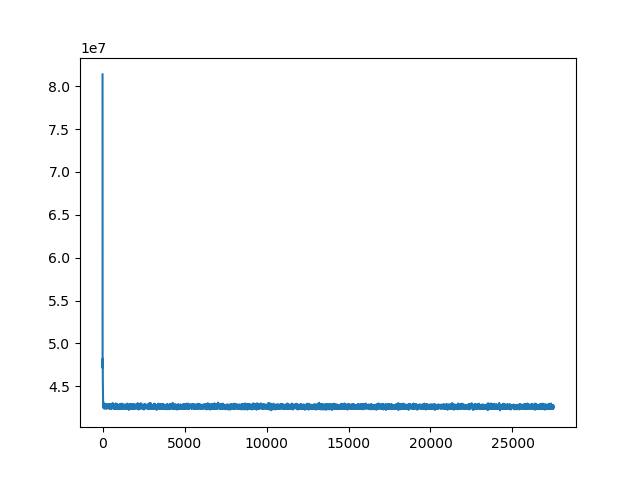

In [80]:
figure()
semilogy(Logger2.val_dict['hyper_params.std_lik'])
figure()
semilogy(Logger2.val_dict['stored_K.K0._lengthscale_storage'])
figure()
semilogy(Logger2.val_dict['stored_K.K0._amplitude_storage'])
figure()
semilogy(Logger2.val_dict['stored_K.K1._lengthscale_storage'])
figure()
semilogy(Logger2.val_dict['stored_K.K1._amplitude_storage'])
figure()
plot(Logger2.val_dict['loss'])

<IPython.core.display.Javascript object>


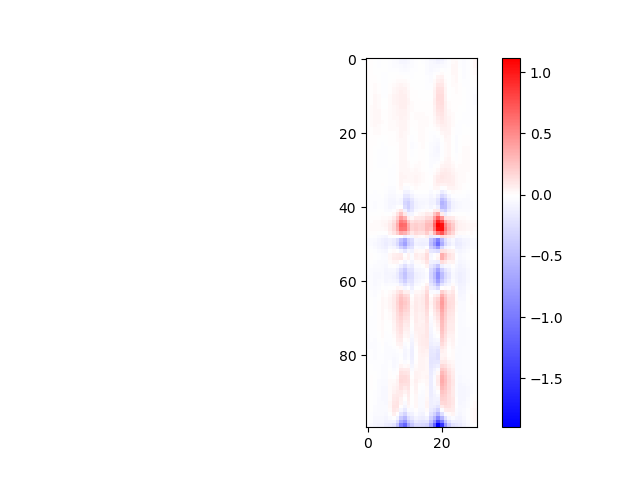

In [86]:
cmap = shiftedColorMap(matplotlib.cm.bwr,midpoint=0.63)
figure()
μ = m2.predict_mean().reshape(30,100).t()
imshow(μ.detach().numpy() - Y/Yc.mean(),cmap=cmap)
colorbar()

<IPython.core.display.Javascript object>


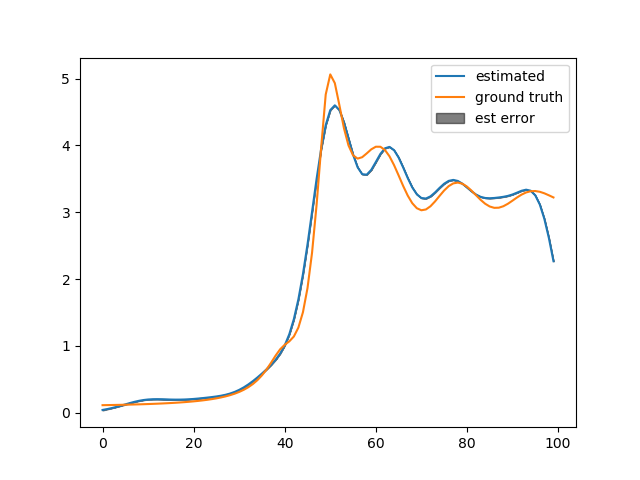

In [87]:
figure()
μ = m2.predict_mean().reshape(30,100).t().detach().numpy()[:,9]
σ = m2.predict_var().reshape(30,100).t().detach().numpy()[:,9]
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(Y[:,9]/Yc.mean(),label='ground truth')
legend()

<IPython.core.display.Javascript object>


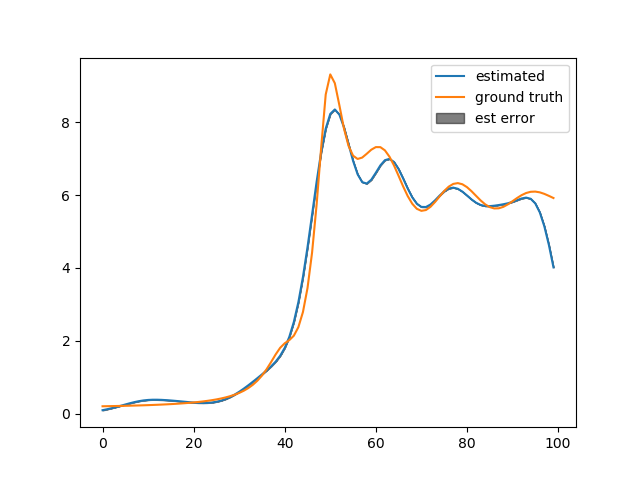

In [88]:
figure()
μ = m2.predict_mean().reshape(30,100).t().detach().numpy()[:,19]
σ = m2.predict_var().reshape(30,100).t().detach().numpy()[:,19]
plot(μ, label='estimated')
fill_between(np.arange(100),μ+σ,μ-σ,color='k',alpha=0.5,label='est error')
plot(Y[:,19]/Yc.mean(),label='ground truth')
legend()